# Modeling the Major Indices: 
- S&P 500
- Nasdaq
- Dow Jones
- Russell 2000

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

from inferencial_functions import describe_predictions, plot_test_accuracy
from other_functions import compare_curves
from classification_classes import Importance
sns.set_style("dark")
pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 45)

In [2]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

In [3]:
def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [4]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                         'Twelve_Month_Change'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131)
    return X_train, X_test, y_train, y_test

### Importing Data

In [5]:
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDICES_FILLED.csv')
df.head(4)

Date Ticker  Adj Close      Close       High        Low  Open  \
0  1964-02-06  ^GSPC  76.930000  76.930000  77.260002  76.470001   0.0   
1  1964-02-07  ^GSPC  77.180000  77.180000  77.510002  76.660004   0.0   
2  1964-02-10  ^GSPC  77.050003  77.050003  77.769997  76.830002   0.0   
3  1964-02-11  ^GSPC  77.330002  77.330002  77.650002  76.809998   0.0   

      Volume  GDP_Filled  Interest_Rates  Mkt-RF     SMB     HML     RMW  \
0  4110000.0     669.822            3.50  0.0024  0.0006 -0.0023  0.0004   
1  4710000.0     669.822            3.52  0.0037 -0.0006  0.0014  0.0008   
2  4150000.0     669.822            3.53 -0.0013  0.0017 -0.0020  0.0013   
3  4040000.0     669.822            3.52  0.0033 -0.0003 -0.0014  0.0021   

      CMA  garman_klass_vol        RSI  ...  dollar_volume(M)  Quarter  Month  \
0  0.0006               NaN  64.329769  ...          316.1823        1      2   
1  0.0036               NaN  68.197375  ...          363.5178        1      2   
2 -0.0016               NaN  64.376738  ...          319.7575        1      2   
3  0.0038               NaN  68.391587  ...          312.4132        1      2   

   cycle_year  day_of_week  one_months_later  three_months_later  \
0           4     Thursday        1964-03-06          1964-05-06   
1           4       Friday        1964-03-09          1964-05-07   
2           4       Monday        1964-03-10          1964-05-11   
3           4      Tuesday        1964-03-11          1964-05-11   

   six_months_later  twelve_months_later  One_Month_Change  \
0        1964-08-06           1965-02-08          0.017938   
1        1964-08-07           1965-02-08          0.014900   
2        1964-08-10           1965-02-10          0.019987   
3        1964-08-11           1965-02-11          0.020949   

   Three_Month_Change Six_Month_Change Twelve_Month_Change One_Month_Positive  \
0            0.053685         0.057325            0.130248                1.0   
1            0.051438         0.060637            0.126587                1.0   
2            0.049968         0.061389            0.122128                1.0   
3            0.046166         0.057287            0.106168                1.0   

  Three_Month_Positive Six_Month_Positive  Twelve_Month_Positive  
0                  1.0                1.0                    1.0  
1                  1.0                1.0                    1.0  
2                  1.0                1.0                    1.0  
3                  1.0                1.0                    1.0  

[4 rows x 41 columns]

In [6]:
# Change to Datetime

df["Date"] = pd.to_datetime(df["Date"])

In [7]:
# Move the Date to the index column

df.set_index("Date", inplace=True)

# Data Understanding
Looking at this market data from the index level reduces the overall volatility of the markets as much as possible. Each of these indexes is made up of many stocks, and therefore insulated against the outsized swings of any individual stocks within the index. The Dow is primarily legacy industrial, staple, and financial stocks, and is imbalanced relatively infrequently, the S&P 500 is composed of the 500 largest market cap US listed companies from a variety of sectors, the Nasdaq is made up primarily of tech companies, and the Russell 2000 are small cap stocks, many of whom are not yet profitable, but have tremendous potential for growth. 

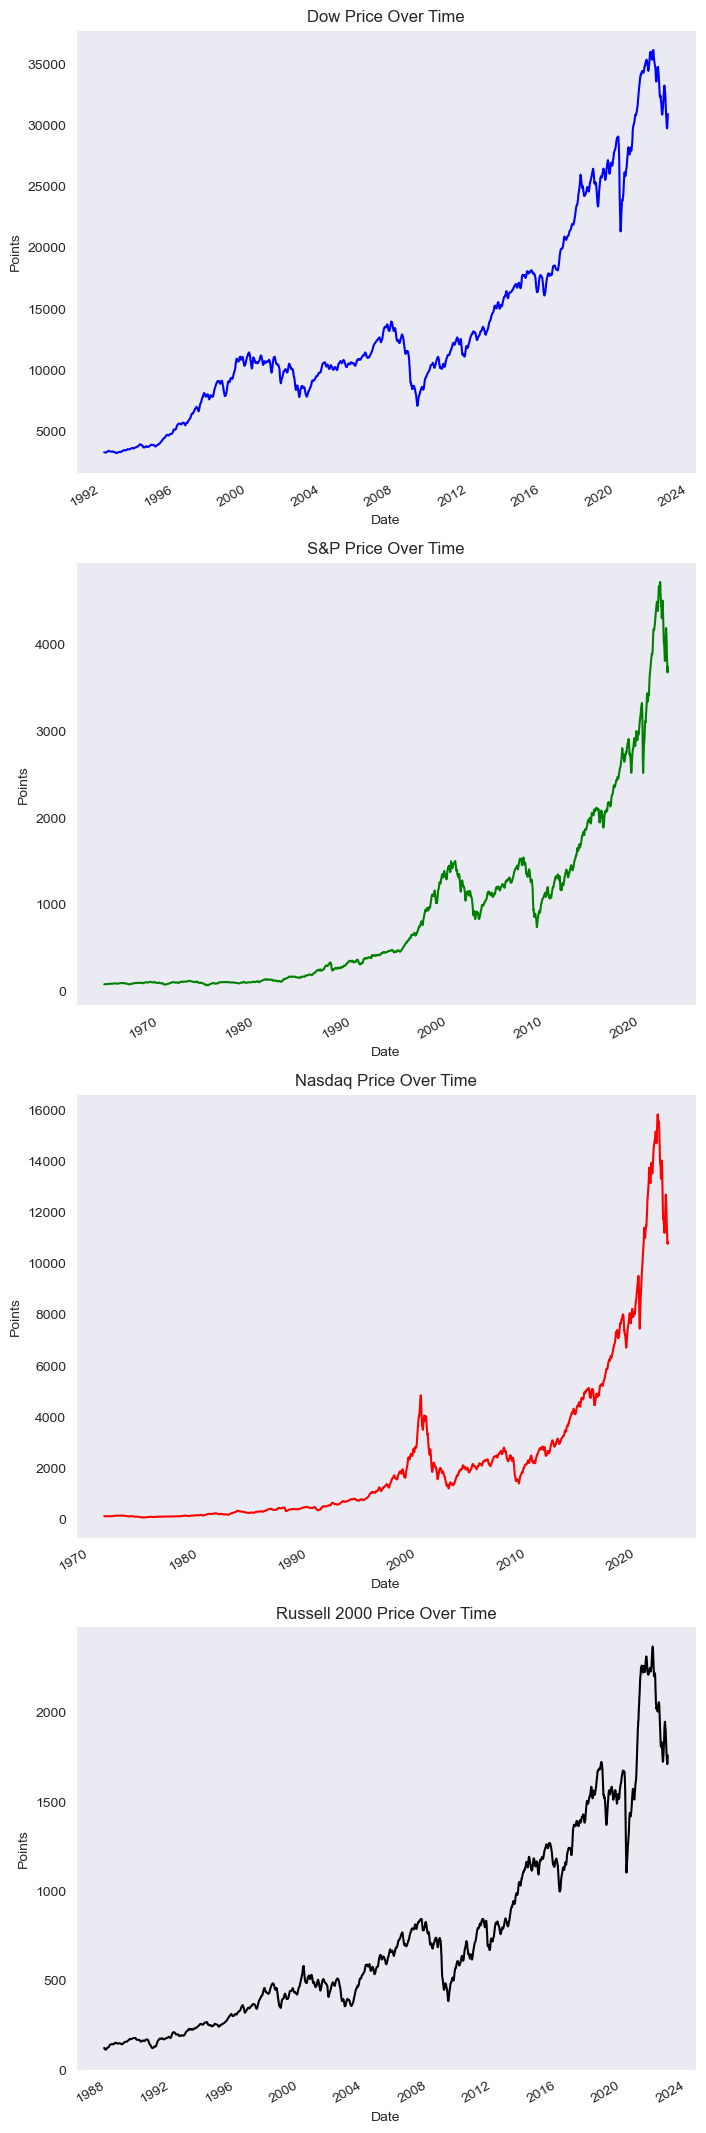

In [8]:
# Plots of the indices, smoothed using 20-day moving averages
fig, ax = plt.subplots(nrows=4, figsize=(8,30))

df[df["Ticker"] == "^DJI"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="blue", ax=ax[0])
ax[0].set_ylabel("Points")
ax[0].set_title("Dow Price Over Time")

df[df["Ticker"] == "^GSPC"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="green", ax=ax[1])
ax[1].set_ylabel("Points")
ax[1].set_title("S&P Price Over Time")

df[df["Ticker"] == "^IXIC"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="red", ax=ax[2])
ax[2].set_ylabel("Points")
ax[2].set_title("Nasdaq Price Over Time")

df[df["Ticker"] == "^RUT"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="black", ax=ax[3])
ax[3].set_ylabel("Points")
ax[3].set_title("Russell 2000 Price Over Time");

### Heatmap
The features exhibiting the strongest correlation with one another are all related to the specific price of the moment, and therefore, the strength of these correlations is not a surprise.

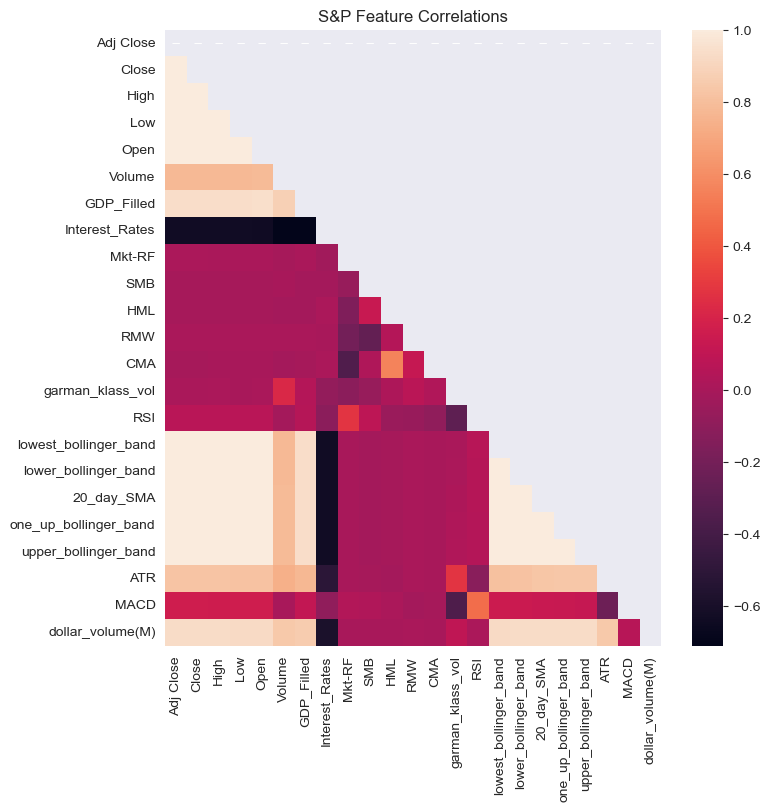

In [10]:
# Heatmap of S&P Correlations

fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("dark")

mask = np.triu(np.ones_like(df.drop(columns=["Ticker", "one_months_later", 'three_months_later',\
                                             'six_months_later', 'twelve_months_later', 'One_Month_Positive',\
                                             'Three_Month_Positive','Six_Month_Positive','Twelve_Month_Positive',\
                                             'Quarter', 'Month', 'cycle_year', 'day_of_week', 'One_Month_Change', \
                                             'Three_Month_Change', 'Six_Month_Change','Twelve_Month_Change']).corr()))


sns.heatmap(df[df["Ticker"] == "^GSPC"].drop(columns=\
                ["Ticker", "one_months_later", 'three_months_later',\
                                             'six_months_later', 'twelve_months_later', 'One_Month_Positive',\
                                             'Three_Month_Positive','Six_Month_Positive','Twelve_Month_Positive',\
                                             'Quarter', 'Month', 'cycle_year', 'day_of_week', 'One_Month_Change', \
                                             'Three_Month_Change', 'Six_Month_Change','Twelve_Month_Change']).corr(),\
            mask=mask, annot=True, ax=ax)

ax.set_title("S&P Feature Correlations");

### Correlations to Target

In [11]:
df.reset_index(inplace=True)

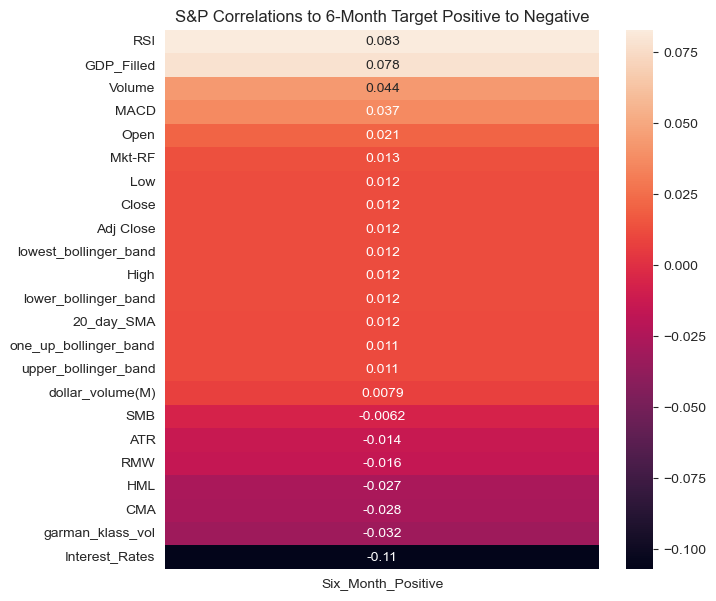

In [12]:
# S&P heatmap of correlations to target

fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("dark")

sns.heatmap(df[df["Ticker"] == "^GSPC"].drop(columns=\
        ["Date", "Ticker", "one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later',\
         'One_Month_Positive', 'Three_Month_Positive', 'Twelve_Month_Positive', 'Quarter', 'Month',\
         'cycle_year', 'day_of_week', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
         'Twelve_Month_Change']).corr()[["Six_Month_Positive"]].sort_values(by="Six_Month_Positive", \
                                                                            ascending=False)[1:], annot=True, ax=ax)

ax.set_title("S&P Correlations to 6-Month Target Positive to Negative");

<hr style="border: 3px solid black">

# Missing Data
The missing data is exclusively Garman-Klass Vol. Other technical indicators have already been dropped which intially require a fixed window of time to generate. Also logically for recent history, it is impossible to label the outcomes of dates a year into the future that have yet to pass, so the data ends around Fall 2022. 

In [13]:
# Shows the amount of data to be dropped in order to consolidate everything into null-free data

df.shape[0], df.shape[0] - df.dropna().shape[0]

(43966, 4491)

### Setting up the df properly

In [14]:
df.set_index("Date", inplace=True)
df["day_of_week"] = df["day_of_week"].astype(str)
df["Quarter"] = df["Quarter"].astype(str)
df["Month"] = df["Month"].astype(str)
df["cycle_year"] = df['cycle_year'].astype(str)

In [15]:
# Unique DF's based on the TARGET time horizon 

one_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                'twelve_months_later', 'Three_Month_Positive', 'Six_Month_Positive', \
                                'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])


three_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                  'twelve_months_later', 'One_Month_Positive', 'Six_Month_Positive', \
                                  'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])


six_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later',\
                                'One_Month_Positive', 'Three_Month_Positive', 'Twelve_Month_Positive',\
                               'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', 'Twelve_Month_Change'])


twelve_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                   'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', \
                                   'Six_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])

In [16]:
# For Verification

twelve_month_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43966 entries, 1964-02-06 to 2022-11-02
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 43966 non-null  object 
 1   Adj Close              43966 non-null  float64
 2   Close                  43966 non-null  float64
 3   High                   43966 non-null  float64
 4   Low                    43966 non-null  float64
 5   Open                   43966 non-null  float64
 6   Volume                 43966 non-null  float64
 7   GDP_Filled             43966 non-null  float64
 8   Interest_Rates         43966 non-null  float64
 9   Mkt-RF                 43966 non-null  float64
 10  SMB                    43966 non-null  float64
 11  HML                    43966 non-null  float64
 12  RMW                    43966 non-null  float64
 13  CMA                    43966 non-null  float64
 14  garman_klass_vol       39475 non-null

<hr style="border: 2px solid green">

### Re-Visiting Macro Data for Six Month Windows
To provide a bit of insight into how Macro Economic factors like GDP and federal interest rates impact stock returns, we will look at those features' characteristics when they appreciate over a 6 month period, and when they do not.

In [17]:
# Macro Statistics when indices increase in value over a 6 month period

df[df["Six_Month_Positive"] == 1][["GDP_Filled", "Interest_Rates"]].describe()

GDP_Filled  Interest_Rates
count  30033.000000    30033.000000
mean   10966.181758        3.571803
std     6467.165622        3.041161
min      669.822000       -0.050000
25%     6004.733000        0.330000
50%     9900.169000        3.640000
75%    16319.541000        5.310000
max    26408.405000       17.140000

##### GDP
`Mean GDP is slightly higher when indices increase in value`, and the `Median GDP is surprisingly LOWER` for times when indices increase in value `over 6 months` compared to when they do not.

##### Interest Rates 
Over 6 months, mean Interest Rates are `slightly lower when indices increase in value`, and `median interest rates are also slightly lower` when indices increase in value. 

In [19]:
# Macro Statistics when indices do not increase in value over a 6 month period 

df[df["Six_Month_Positive"] == 0][["GDP_Filled", "Interest_Rates"]].describe()

GDP_Filled  Interest_Rates
count  13933.000000    13933.000000
mean   10692.932357        4.071540
std     7092.895746        3.308188
min      697.319000       -0.010000
25%     4507.894000        1.590000
50%    10470.231000        3.850000
75%    14898.999000        5.980000
max    26408.405000       17.010000

In [20]:
six_month_df["Six_Month_Positive"].value_counts()

Six_Month_Positive
1.0    30033
0.0    13933
Name: count, dtype: int64

In [21]:
# It makes sense that Interest Rates would be negatively correlated, but it is a bit strange that GDP is also

six_month_df[["Six_Month_Positive", "GDP_Filled", "Interest_Rates"]].corr()[["GDP_Filled", "Interest_Rates"]][0:1]

GDP_Filled  Interest_Rates
Six_Month_Positive    0.019052       -0.074124

In [22]:
# The technical indicators exhibit the strongest correlation, but nothing to an objectionable level

print("Top 5 Most Positive Correlations")
six_month_df.drop(columns=["Ticker", "day_of_week", "Quarter", "Month", 'cycle_year']).corr()\
["Six_Month_Positive"].sort_values(ascending=False)[1:6]

Top 5 Most Positive Correlations


RSI           0.044623
GDP_Filled    0.019052
MACD          0.017134
Mkt-RF        0.010494
Open         -0.006430
Name: Six_Month_Positive, dtype: float64

In [23]:
# Entries per index -> going back to 1964 for the S&P, more recent for other indices
print(df.index.min())
df["Ticker"].value_counts()

1964-02-06 00:00:00


Ticker
^GSPC    14634
^IXIC    12891
^RUT      8759
^DJI      7682
Name: count, dtype: int64

<hr style="border: 2px solid purple">

# Breaking Data into Index Groups

### Dow Jones

In [24]:
# Different groups for each respective target time horizon

dow_one_month = one_month_df[one_month_df["Ticker"] == "^DJI"]
dow_three_month = three_month_df[three_month_df["Ticker"] == "^DJI"]
dow_six_month = six_month_df[six_month_df["Ticker"] == "^DJI"]
dow_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^DJI"]

dow_one_month.shape, dow_twelve_month.shape

((7682, 29), (7682, 29))

### S&P 500

In [25]:
# Different groups for each respective target time horizon

SnP_one_month = one_month_df[one_month_df["Ticker"] == "^GSPC"]
SnP_three_month = three_month_df[three_month_df["Ticker"] == "^GSPC"]
SnP_six_month = six_month_df[six_month_df["Ticker"] == "^GSPC"]
SnP_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^GSPC"]

SnP_one_month.shape, SnP_twelve_month.shape

((14634, 29), (14634, 29))

### Nasdaq Composite

In [26]:
# Different groups for each respective target time horizon

nasdaq_one_month = one_month_df[one_month_df["Ticker"] == "^IXIC"]
nasdaq_three_month = three_month_df[three_month_df["Ticker"] == "^IXIC"]
nasdaq_six_month = six_month_df[six_month_df["Ticker"] == "^IXIC"]
nasdaq_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^IXIC"]

nasdaq_one_month.shape, nasdaq_twelve_month.shape

((12891, 29), (12891, 29))

### Russell 2000

In [27]:
# Different groups for each respective target time horizon

russell_one_month = one_month_df[one_month_df["Ticker"] == '^RUT']
russell_three_month = three_month_df[three_month_df["Ticker"] == '^RUT']
russell_six_month = six_month_df[six_month_df["Ticker"] == '^RUT']
russell_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == '^RUT']

russell_one_month.shape, russell_twelve_month.shape

((8759, 29), (8759, 29))

# Class For Data Collection, pre-model Prep

In [28]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, X_train, X_test, y_train, y_test, threshold=.5):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.threshold = threshold
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        if self.threshold == .5:
            self.y_pred = self.model.predict(self.X_test)
        else:
            self.y_pred = (self.model.predict_proba(self.X_test)[:, 1] >= self.threshold).astype(int)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        sns.set_style("dark")
        fig, ax = plt.subplots(figsize=(6,6))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, label=f"{self.name} | AUC: {self.auc:.2f})")
        # Y-axis
        ax.set_yticks([0,.2,.4,.6,.8,1])
        ax.set_yticklabels([0,20,40,60,80,100])
        ax.set_ylabel("True Positive %")
        # X-axis
        ax.set_xticks([0,.2,.4,.6,.8,1])
        ax.set_xticklabels([0,20,40,60,80,100])
        ax.set_xlabel("False Positive %")
        ax.set_title(f"{self.name} ROC Curve", fontsize=20)
        plt.grid(False);
        
        
    def compare_roc_curve(self):
        sns.set_style("dark")
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=30)
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        plt.grid(False);
    
    
    def confusion_matrix(self):
        sns.set_style('white')
        # Confusion Matrix Plot
        fig, ax = plt.subplots(figsize=(6,6))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title(f'Confusion Matrix for "{self.name}" Test Data');
    
    
    def __str__(self):
      return f"Model name: {self.name}"

# Dummy Model and Train Test Split

Now that the data has been split into 16 total segments, both by target and then subsequently by index, we can begin to establish a dummy baseline model for classification, and then build out sklearn Pipelines to hand our data pre processing and avoid any kind of data leakage. As you can see, the longer the time horizon, the more likely the most frequently occuring class would be the correct prediction. Given that, I will start with the 12 Month target groups, and go backward from there.

In [29]:
# Showing the ratios of gains to losses at different timeframes

print(one_month_df["One_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), 
      three_month_df["Three_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), \
      six_month_df["Six_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), 
      twelve_month_df["Twelve_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}))

One_Month_Positive
Profitable        26891
Not Profitable    17075
Name: count, dtype: int64 Three_Month_Positive
Profitable        28489
Not Profitable    15477
Name: count, dtype: int64 Six_Month_Positive
Profitable        30033
Not Profitable    13933
Name: count, dtype: int64 Twelve_Month_Positive
Profitable        32561
Not Profitable    11405
Name: count, dtype: int64


### Large Cell with commented out groups to avoid having to constantly re-enter the code

In [30]:
# Creating X and y groups

                # DOW GROUPS

# X = dow_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = dow_one_month["One_Month_Positive"]

# X = dow_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = dow_three_month["Three_Month_Positive"]

# X = dow_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = dow_six_month["Six_Month_Positive"]

X = dow_twelve_month.drop(columns=["Ticker", "Twelve_Month_Positive"])
y = dow_twelve_month["Twelve_Month_Positive"]


                # S&P GROUPS

# X = SnP_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = SnP_one_month["One_Month_Positive"]

# X = SnP_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = SnP_three_month["Three_Month_Positive"]

# X = SnP_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = SnP_six_month["Six_Month_Positive"]

# X = SnP_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = SnP_twelve_month["Twelve_Month_Positive"]


                # NASDAQ GROUPS

# X = nasdaq_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = nasdaq_one_month["One_Month_Positive"]

# X = nasdaq_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = nasdaq_three_month["Three_Month_Positive"]

# X = nasdaq_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = nasdaq_six_month["Six_Month_Positive"]

# X = nasdaq_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = nasdaq_twelve_month["Twelve_Month_Positive"]


                # RUSSELL GROUPS

# X = russell_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = russell_one_month["One_Month_Positive"]

# X = russell_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = russell_three_month["Three_Month_Positive"]

# X = russell_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = russell_six_month["Six_Month_Positive"]

# X = russell_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = russell_twelve_month["Twelve_Month_Positive"]

In [31]:
# 3.4 to 1 ratio for Dow 12 Month Return, a little bit imbalanced but not horrendous

y.value_counts()

Twelve_Month_Positive
1.0    5992
0.0    1690
Name: count, dtype: int64

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7682 entries, 1992-02-06 to 2022-11-02
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Adj Close              7682 non-null   float64
 1   Close                  7682 non-null   float64
 2   High                   7682 non-null   float64
 3   Low                    7682 non-null   float64
 4   Open                   7682 non-null   float64
 5   Volume                 7682 non-null   float64
 6   GDP_Filled             7682 non-null   float64
 7   Interest_Rates         7682 non-null   float64
 8   Mkt-RF                 7682 non-null   float64
 9   SMB                    7682 non-null   float64
 10  HML                    7682 non-null   float64
 11  RMW                    7682 non-null   float64
 12  CMA                    7682 non-null   float64
 13  garman_klass_vol       7682 non-null   float64
 14  RSI                    7682 non-null  

<hr style="border: 4px solid royalblue">

# Train Test Split

In [33]:
# The actual data split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1313)

# Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [34]:
dummy = DummyClassifier(strategy="most_frequent")

In [35]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [36]:
dummy_model_first = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


In [37]:
Model.model_df

name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.778511    0.778511           1.0  0.875464   

   train_logloss  test_accuracy  test_prec  test_recall  test_f1  \
0       7.983281       0.784487   0.784487          1.0  0.87923   

   test_logloss  AUC  
0      7.767867  0.5

In [38]:
"Dummy Test Score:", dummy_model_first.test_score, "*"*80, y_test.value_counts(normalize=True)

('Dummy Test Score:',
 0.784487246225924,
 '********************************************************************************',
 Twelve_Month_Positive
 1.0    0.784487
 0.0    0.215513
 Name: proportion, dtype: float64)

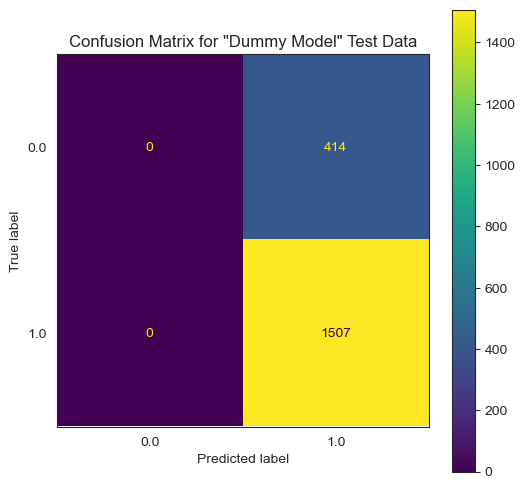

In [39]:
dummy_model_first.confusion_matrix()

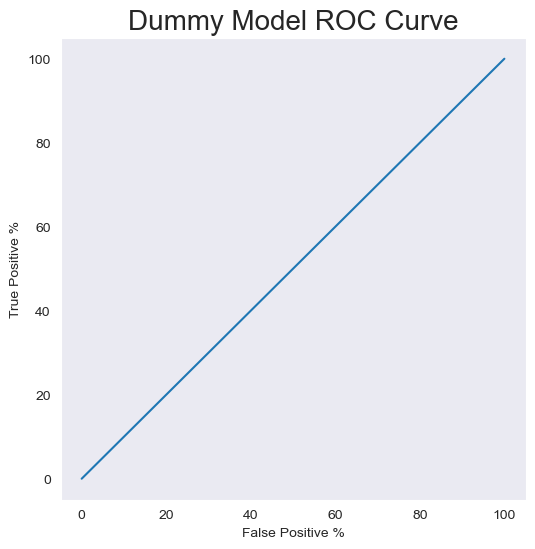

In [40]:
dummy_model_first.roc_curve()

<hr style="border: 2px solid blue;">

# Pipelines

Now that I have established a dummy baseline for our predictions, I can begin to iterate through different models using sklearn pipelines. Because my data is composed of continuous numeric values, I will only need to `SCALE` the data before processing it. I will use a variety of different models in an attempt to best predict the qualitative performance of the market on different time horizons.

In [41]:
X_train.head(2)

Adj Close        Close         High          Low         Open  \
Date                                                                          
1997-11-25  7809.000000  7809.000000  7821.390137  7739.569824  7767.200195   
1997-12-09  8049.700195  8049.700195  8111.089844  8029.770020  8110.799805   

                Volume  GDP_Filled  Interest_Rates  Mkt-RF     SMB     HML  \
Date                                                                         
1997-11-25  56360000.0    8765.907            5.16  0.0035 -0.0067  0.0014   
1997-12-09  51060000.0    8765.907            5.13 -0.0074 -0.0013  0.0079   

               RMW     CMA  garman_klass_vol        RSI  \
Date                                                      
1997-11-25  0.0047  0.0040          0.000044  52.141419   
1997-12-09  0.0015  0.0039          0.000029  57.436110   

            lowest_bollinger_band  lower_bollinger_band   20_day_SMA  \
Date                                                                   
1997-11-25            7353.275311           7491.194418  7629.113525   
1997-12-09            7397.839935           7609.424215  7821.008496   

            one_up_bollinger_band  upper_bollinger_band         ATR  \
Date                                                                  
1997-11-25            7767.032632           7904.951740  137.395758   
1997-12-09            8032.592777           8244.177058  117.292373   

                  MACD  dollar_volume(M) Quarter Month cycle_year day_of_week  
Date                                                                           
1997-11-25    4.046021        440115.240       4    11          1     Tuesday  
1997-12-09  100.577739        411017.692       4    12          1     Tuesday

### Sub-Pipes/Column Transformer

In [42]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ('knn', KNNImputer(add_indicator=True)),
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [54]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


pipeline = Pipeline(steps=[
    ('ct', ct),
    ('model', KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
                                metric='minkowski', metric_params=None, n_jobs=4)
    
    )])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('knn',
                                                                   KNNImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd57703fd90>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd57703fdc0>)])),
                ('lr', KNeighborsClassifier(n_jobs=4))])

In [56]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# KNN1 = Model("K Nearest Neighbors 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

name  train_accuracy  train_prec  train_recall  \
2        Random Forest 12-Month Dow        0.971880    0.978370      0.985730   
3          Extra Trees 12-Month Dow        0.974657    0.982890      0.984615   
5              XGBoost 12-Month Dow        0.966499    0.974632      0.982609   
6  K Nearest Neighbors 12-Month Dow        0.933693    0.945223      0.971237   
4             AdaBoost 12-Month Dow        0.926751    0.937576      0.970569   
1  Logistic Regression 12-Month Dow        0.809582    0.838024      0.936455   
0                       Dummy Model        0.778511    0.778511      1.000000   

   train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
2  0.982009       0.092518       0.977095   0.980302     0.990710  0.985479   
3  0.983734       0.092329       0.977095   0.986047     0.984738  0.985392   
5  0.978577       0.113769       0.971369   0.975754     0.988056  0.981866   
6  0.958002       0.390906       0.943259   0.957461     0.970803  0.964086   
4  0.953762       0.638506       0.938574   0.943204     0.980756  0.961614   
1  0.884489       0.400412       0.813639   0.841761     0.938952  0.887704   
0  0.875464       7.983281       0.784487   0.784487     1.000000  0.879230   

   test_logloss       AUC  
2      0.074499  0.996487  
3      0.065541  0.996436  
5      0.086271  0.994371  
6      0.447149  0.965373  
4      0.638158  0.977488  
1      0.388727  0.840307  
0      7.767867  0.500000

<hr style="border: 2px solid red">

# Notes on models for 12 Month Dow
- log_reg1 2.7% increase in test accuracy, so marginal improvement. Log loss significantly better
- rf1 MASSIVE performance improvements in every statistical category.
- ET1 Extra Trees Default performed even slightly better than RandomForest! near perfect
- AdaBoost is once again significantly better than Logistic Regression and dummy, but worse than Extra/Random Tree
- XGBoost also very good, 2nd only to Extra Trees at this point
- KNN is a definite step down from the boosted/tree classifiers
- Voting Ensemble is basically inline with the other tree ensemble methods, EXTRA TREES still best
- Stacking ensemble, FWIW, has an AUC of 1, very slightly less accurate but ALSO more precise

 ### Final Note: In spite of exceptional performance, none of the models are overfit

# 12 Month Dow Stats

In [146]:
Model.model_df.sort_values(by="test_accuracy", ascending=False)

name  train_accuracy  train_prec  train_recall  \
2        Random Forest 12-Month Dow        0.971880    0.978370      0.985730   
3          Extra Trees 12-Month Dow        0.974657    0.982890      0.984615   
5              XGBoost 12-Month Dow        0.966499    0.974632      0.982609   
6  K Nearest Neighbors 12-Month Dow        0.933693    0.945223      0.971237   
4             AdaBoost 12-Month Dow        0.926751    0.937576      0.970569   
1  Logistic Regression 12-Month Dow        0.809582    0.838024      0.936455   
0                       Dummy Model        0.778511    0.778511      1.000000   

   train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
2  0.982009       0.092518       0.977095   0.980302     0.990710  0.985479   
3  0.983734       0.092329       0.977095   0.986047     0.984738  0.985392   
5  0.978577       0.113769       0.971369   0.975754     0.988056  0.981866   
6  0.958002       0.390906       0.943259   0.957461     0.970803  0.964086   
4  0.953762       0.638506       0.938574   0.943204     0.980756  0.961614   
1  0.884489       0.400412       0.813639   0.841761     0.938952  0.887704   
0  0.875464       7.983281       0.784487   0.784487     1.000000  0.879230   

   test_logloss       AUC  
2      0.074499  0.996487  
3      0.065541  0.996436  
5      0.086271  0.994371  
6      0.447149  0.965373  
4      0.638158  0.977488  
1      0.388727  0.840307  
0      7.767867  0.500000

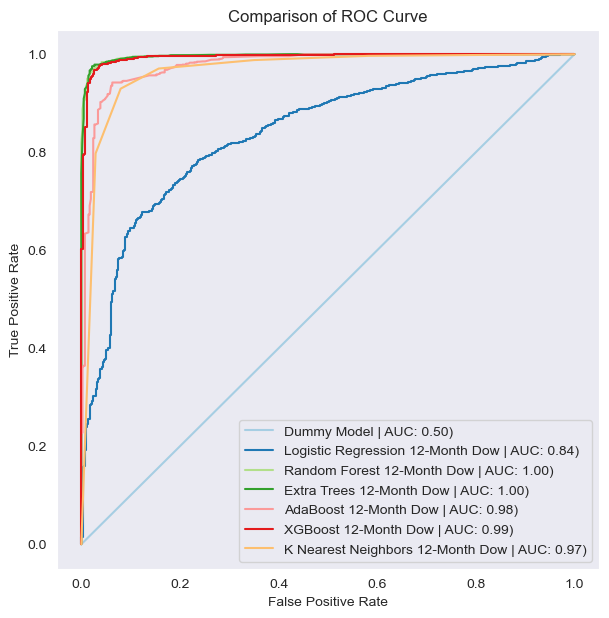

In [147]:
log_reg1.compare_roc_curve()

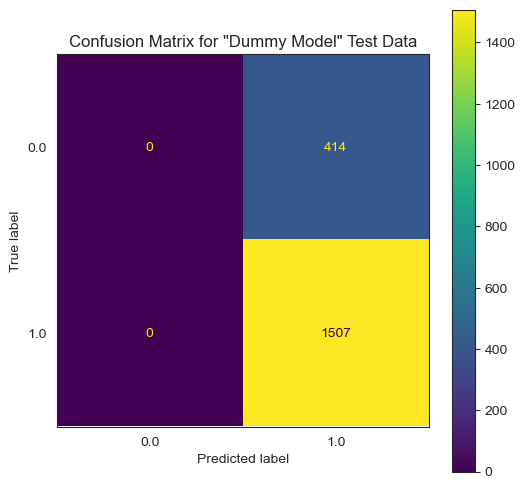

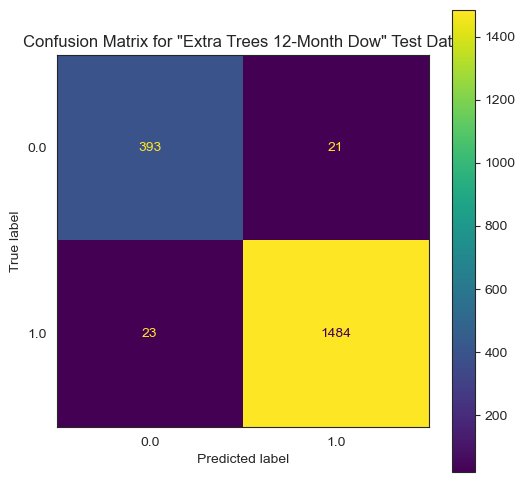

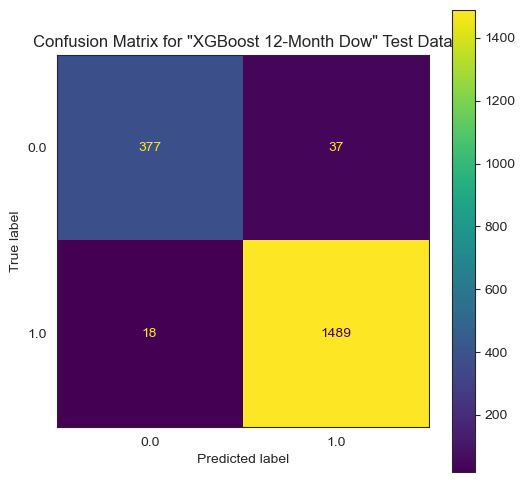

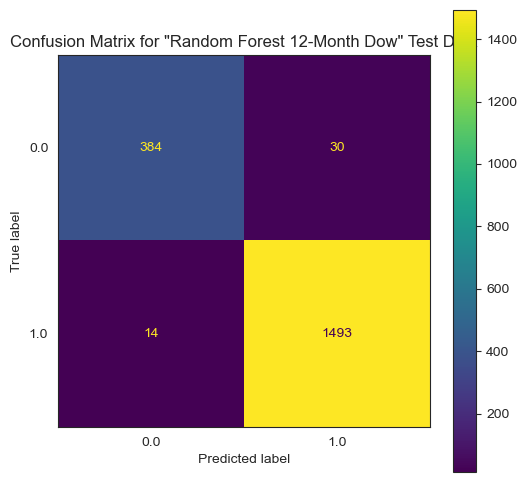

In [57]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model_first, ET1, XGB1, rf1]:
    i.confusion_matrix()

In [62]:
# Feature importances

features = list(rf1.model.get_params()["ct"].get_feature_names_out())
features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

imp_feats = rf1.model.get_params()['lr'].feature_importances_

imp_list = list(zip(features_list, imp_feats))
imp_dict = dict(imp_list)

Importance(imp_dict)

print("Top 5 Feature Importances")
for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
    print(i)

Top 5 Feature Importances
('GDP_Filled', 0.12474621015322254)
('Interest_Rates', 0.11237213711611005)
('ATR', 0.0815304966293952)
('20_day_SMA', 0.05399960970043672)
('lowest_bollinger_band', 0.05284224214549763)


In [69]:
# All importances 
Importance.df

Adj Close    Close      High       Low   Open    Volume  GDP_Filled  \
0   0.042924  0.04551  0.043958  0.038064    NaN  0.024236    0.124746   

   Interest_Rates    Mkt-RF       SMB      HML      RMW      CMA  \
0        0.112372  0.007291  0.006855  0.00818  0.00973  0.01122   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.012537  0.020223               0.052842              0.044705   

   ...   Month_2   Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
0  ...  0.000922  0.001931  0.002368  0.002177  0.000805  0.003433  0.001308   

    Month_9  cycle_year_1  cycle_year_2  cycle_year_3  cycle_year_4  \
0  0.004036        0.0049      0.008934      0.023062      0.009373   

   day_of_week_Friday  day_of_week_Monday  day_of_week_Thursday  \
0            0.000845            0.000835              0.000577   

   day_of_week_Tuesday  day_of_week_Wednesday  
0             0.000715               0.000657  

[1 rows x 48 columns]

<hr style="border: 2px solid red;">

# Functions to expedite the process

In [70]:
def dummy_model(model_type, sector_name, time_period):
    # Dummy Classifier for new time horizon
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)


    # CHANGE THE CLASS EACH TIME IT'S APPROPRIATE
    return model_type(f"Dummy {sector_name} {str(time_period)}-Month", dummy, X_train, X_test, y_train, y_test)


def l_regr(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
                                    fit_intercept=True)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Logistic Regression {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)



def r_forest(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
                                  oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Random Forest {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

def extra_trees(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
    min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
    bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
    ccp_alpha=0.0, max_samples=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Extra Trees {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

def x_g_b(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} XGBoost {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)





def knn(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
                                metric='minkowski', metric_params=None, n_jobs=4)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} KNN {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)



def best_etc_grid(estimator, model_type, sector_name, time_period):
    # Parameters to search through

    params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
             'model__max_depth': [None, 7, 5],
             'model__max_features': ["auto", "sqrt", "log2"],
             "model__ccp_alpha": [0, .001, .01, .1],
         }
    
# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, verbose=1)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_type(f"GridSearched Best-Model, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)


<hr style="border: 4px solid blue">

# 1 Month Dow

Now that we began with the 12 Month Dow modeling, we will iterate through every permutation of index and targets and see how well we do with our models.

# df objects to streamline modeling

In [71]:
# DFs for each ETF

# DOW
dow_df = df[df["Ticker"]== "^DJI"]

# S&P
sp_df = df[df["Ticker"]== "^GSPC"]

# Nasdac
nas_df = df[df["Ticker"]== "^IXIC"]

# Russel
rus_df = df[df["Ticker"]== "^RUT"]

In [75]:
# Create variables

X_train, X_test, y_train, y_test = select_data(dow_df, "One")

# Create Model Objects

# dummy_D_1_month = dummy_model(Model, "Dow", 1)
# logreg_D_1_month = l_regr(Model, "Dow", 1)
# knn_D_1_month = knn(Model, "Dow", 1)
# rfc_D_1_month = r_forest(Model, "Dow", 1)
# etc_D_1_month = extra_trees(Model, "Dow", 1)
# XGBoost_D_1_month = x_g_b(Model, "Dow", 1)

# grid_D_1_month = best_etc_grid(estimator=etc_D_1_month.model, model_type=Model, sector_name="Dow", time_period=1)

Model.model_df.iloc[7:].sort_values(by="test_accuracy", ascending=False)

name  train_accuracy  train_prec  \
13  GridSearched Best-Model, 1-Month Dow        0.908349    0.917173   
11               Dow Extra Trees 1-Month        0.905917    0.919138   
10             Dow Random Forest 1-Month        0.894808    0.901853   
12                   Dow XGBoost 1-Month        0.856445    0.873646   
9                        Dow KNN 1-Month        0.770871    0.806612   
8        Dow Logistic Regression 1-Month        0.644499    0.661778   
7                      Dummy Dow 1-Month        0.628190    0.628190   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
13      0.938931  0.927903       0.282523       0.912546   0.927152   
11      0.932299  0.925646       0.284050       0.909943   0.924731   
10      0.934233  0.917744       0.299723       0.901614   0.910642   
12      0.901904  0.887512       0.387603       0.859969   0.877534   
9       0.835583  0.820826       1.256348       0.786569   0.813990   
8       0.887253  0.758058       0.636074       0.648100   0.660934   
7       1.000000  0.771642      13.401405       0.624675   0.624675   

    test_recall   test_f1  test_logloss       AUC  
13     0.933333  0.930233      0.251638  0.963254  
11     0.931667  0.928186      0.266340  0.962881  
10     0.934167  0.922254      0.301463  0.961503  
12     0.901667  0.889437      0.365820  0.926021  
9      0.853333  0.833198      1.057534  0.849824  
8      0.896667  0.760962      0.630811  0.647609  
7      1.000000  0.768984     13.528097  0.500000

In [89]:
# Feature importances
# features_from_trees(grid_D_1_month)
Importance.df

Adj Close     Close      High       Low   Open    Volume  GDP_Filled  \
0   0.042924  0.045510  0.043958  0.038064    NaN  0.024236    0.124746   
1   0.045542  0.044982  0.041996  0.044365    NaN  0.021504    0.034618   

   Interest_Rates    Mkt-RF       SMB      HML      RMW      CMA  \
0        0.112372  0.007291  0.006855  0.00818  0.00973  0.01122   
1        0.042972  0.016104  0.014985  0.01534  0.01560  0.01623   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.012537  0.020223               0.052842              0.044705   
1          0.016895  0.036911               0.041737              0.043550   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0      0.0540               0.042742              0.045540  0.081530   
1      0.0436               0.044567              0.041164  0.038068   

       MACD  ...  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
0  0.018918  ...   0.004483  0.002712  0.002007  0.000584  0.001415  0.000922   
1  0.042957  ...   0.009588  0.011678  0.007211  0.006104  0.006136  0.008858   

    Month_3   Month_4   Month_5   Month_6   Month_7   Month_8   Month_9  \
0  0.001931  0.002368  0.002177  0.000805  0.003433  0.001308  0.004036   
1  0.011358  0.009169  0.008465  0.007731  0.010106  0.008146  0.009715   

   cycle_year_1  cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0       0.00490      0.008934      0.023062      0.009373            0.000845   
1       0.01082      0.014531      0.015104      0.010959            0.007263   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.000835              0.000577             0.000715   
1            0.007064              0.006981             0.006910   

   day_of_week_Wednesday  
0               0.000657  
1               0.006268  

[2 rows x 48 columns]

# Delete below once confirmed ok

In [88]:
list(zip(grid_D_1_month.model.named_steps["ct"].get_feature_names_out(), \
grid_D_1_month.model.get_params()["model"].feature_importances_))

[('num_pipe__Adj Close', 0.045542124346116236),
 ('num_pipe__Close', 0.04498229078424514),
 ('num_pipe__High', 0.041996277084635214),
 ('num_pipe__Low', 0.044364782024366084),
 ('num_pipe__Open', 0.040961309077536055),
 ('num_pipe__Volume', 0.021503857935398284),
 ('num_pipe__GDP_Filled', 0.034617873169528315),
 ('num_pipe__Interest_Rates', 0.04297170896186474),
 ('num_pipe__Mkt-RF', 0.016104333660429224),
 ('num_pipe__SMB', 0.014984753855677425),
 ('num_pipe__HML', 0.01534042349598151),
 ('num_pipe__RMW', 0.015600354612217822),
 ('num_pipe__CMA', 0.016230362215070092),
 ('num_pipe__garman_klass_vol', 0.01689527927493872),
 ('num_pipe__RSI', 0.03691067425514349),
 ('num_pipe__lowest_bollinger_band', 0.04173728867743984),
 ('num_pipe__lower_bollinger_band', 0.04354969706862751),
 ('num_pipe__20_day_SMA', 0.04360012688392244),
 ('num_pipe__one_up_bollinger_band', 0.04456681444014179),
 ('num_pipe__upper_bollinger_band', 0.04116422997729312),
 ('num_pipe__ATR', 0.03806829579174686),
 ('nu

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [503]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.632292    0.632292           1.0  0.774729   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      13.253552       0.617907   0.617907          1.0  0.763835   

   test_logloss  AUC  
0     13.772015  0.5

In [518]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.3s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   7.9s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [519]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   35.5s finished


name  train_accuracy  \
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.899653   
3                              Extra Trees - Default        0.902431   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.879861   
2                            Random Forest - Default        0.880729   
5                           XGBoost - Default Mostly        0.833507   
4                                 AdaBoost - Default        0.695486   
6                      K Nearest Neighbors - Default        0.656771   
1                      Logistic Regression - Default        0.634375   
0                                        Dummy Model        0.632292   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
8    0.917323      0.925046  0.920995       0.292786       0.902655   
3    0.911500      0.936851  0.923912       0.303993       0.899531   
7    0.887748      0.927516  0.907071       0.313328       0.890682   
2    0.891109      0.924494  0.907394       0.339903       0.883915   
5    0.851692      0.892368  0.871391       0.434982       0.848516   
4    0.698560      0.912412  0.791145       0.687158       0.684539   
6    0.704089      0.788575  0.743867       1.830434       0.663196   
1    0.641100      0.957982  0.768126       0.647561       0.627277   
0    0.632292      1.000000  0.774729      13.253552       0.617907   

   test_prec  test_recall   test_f1  test_logloss       AUC  
8   0.913223     0.930918  0.921986      0.247562  0.959968  
3   0.904723     0.935973  0.920083      0.300956  0.959914  
7   0.892369     0.935973  0.913651      0.296728  0.950830  
2   0.891234     0.925021  0.907813      0.327587  0.942169  
5   0.857827     0.904802  0.880689      0.398161  0.912167  
4   0.682360     0.915754  0.782014      0.688724  0.712929  
6   0.699409     0.797810  0.745376      2.125152  0.665011  
1   0.629041     0.967144  0.762284      0.649146  0.609286  
0   0.617907     1.000000  0.763835     13.772015  0.500000

- Log Reg slight improvement
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [ ]:
class DImportance():
    df = pd.DataFrame(columns=['Adj Close', 'Close', 'High', 'Low',' Open', 'Volume', 'GDP_Filled',\
                               'Interest_Rates','Mkt-RF','SMB','HML','RMW','CMA','garman_klass_vol','RSI', \
                               'lowest_bollinger_band', 'lower_bollinger_band', '20_day_SMA', \
                               'one_up_bollinger_band','upper_bollinger_band', 'ATR', 'MACD', 'dollar_volume(M)',\
                               'Quarter_1','Quarter_2','Quarter_3','Quarter_4','Month_1','Month_10','Month_11',\
                               'Month_12','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8',\
                               'Month_9','cycle_year_1','cycle_year_2','cycle_year_3','cycle_year_4',\
                               'day_of_week_Friday',\'day_of_week_Monday','day_of_week_Thursday',\
                               'day_of_week_Tuesday','day_of_week_Wednesday'])
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"

In [194]:
# Extracting feature importances/coefficients
features_from_trees(Model.model_list[12])
# sorted(list(zip(list(X_train.columns), etc_D_1_month.model.get_params()['model'].feature_importances_)),\
#        key= lambda x: x[1], reverse=True)[:5]

Top 5 Feature Importances
('Adj Close', 0.045542124346116236)
('Close', 0.04498229078424514)
('one_up_bollinger_band', 0.04456681444014179)
('Low', 0.044364782024366084)
('20_day_SMA', 0.04360012688392244)


In [ ]:
def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [195]:
Importance.df

Interest Rates  GDP       ATR  lowest_bollinger_band      MACD  \
0             NaN  NaN  0.038068               0.041737  0.042957   
1             NaN  NaN  0.038068               0.041737  0.042957   

   lower_bollinger_band  upper_bollinger_band  20_day_SMA  \
0               0.04355              0.041164      0.0436   
1               0.04355              0.041164      0.0436   

   one_up_bollinger_band     Close      High  Adj Close       Low       RSI  \
0               0.044567  0.044982  0.041996   0.045542  0.044365  0.036911   
1               0.044567  0.044982  0.041996   0.045542  0.044365  0.036911   

       Open  dollar_volume(M)    Volume  garman_klass_vol       SMB      CMA  \
0  0.040961          0.022053  0.021504          0.016895  0.014985  0.01623   
1  0.040961          0.022053  0.021504          0.016895  0.014985  0.01623   

       HML     RMW    Mkt-RF  
0  0.01534  0.0156  0.016104  
1  0.01534  0.0156  0.016104

In [185]:
blahs = list(etc_D_1_month.model.named_steps["ct"].get_feature_names_out())

In [191]:
len(etc_D_1_month.model.get_params()["model"].feature_importances_)

48

In [190]:
blahs2 = [i.replace('num_pipe__', "").replace('cat_pipe__', "") for i in blahs]
len(blahs2)

48

In [179]:
Importance.df

Interest Rates  GDP       ATR  lowest_bollinger_band      MACD  \
0             NaN  NaN  0.038068               0.041737  0.042957   

   lower_bollinger_band  upper_bollinger_band  20_day_SMA  \
0               0.04355              0.041164      0.0436   

   one_up_bollinger_band     Close      High  Adj Close       Low       RSI  \
0               0.044567  0.044982  0.041996   0.045542  0.044365  0.036911   

       Open  dollar_volume(M)    Volume  garman_klass_vol       SMB      CMA  \
0  0.040961          0.022053  0.021504          0.016895  0.014985  0.01623   

       HML     RMW    Mkt-RF  
0  0.01534  0.0156  0.016104

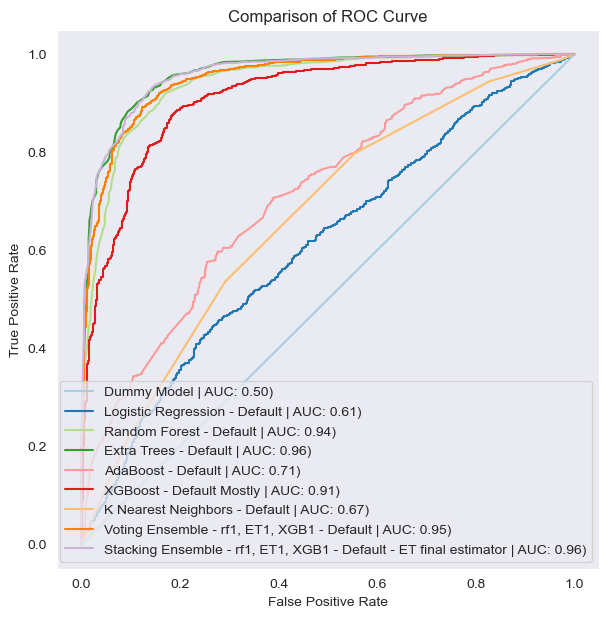

In [522]:
log_reg1.compare_roc_curve()

In [524]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Dow_1_month.csv')

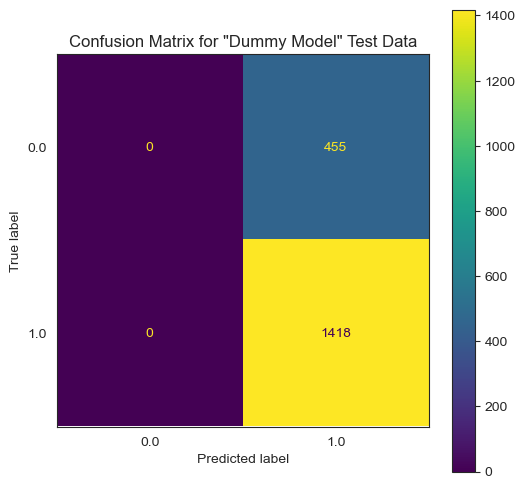

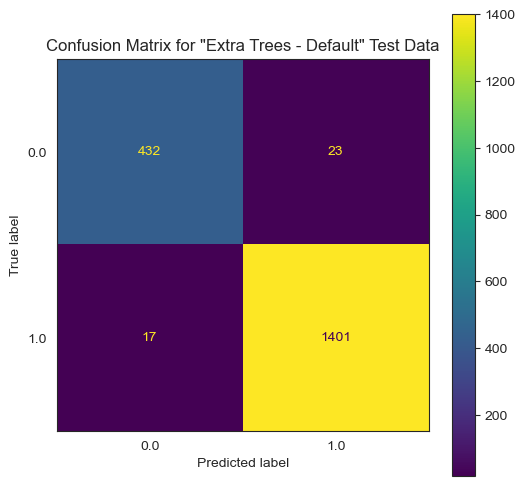

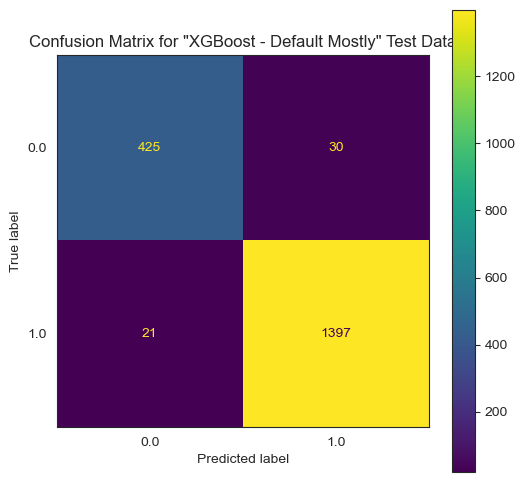

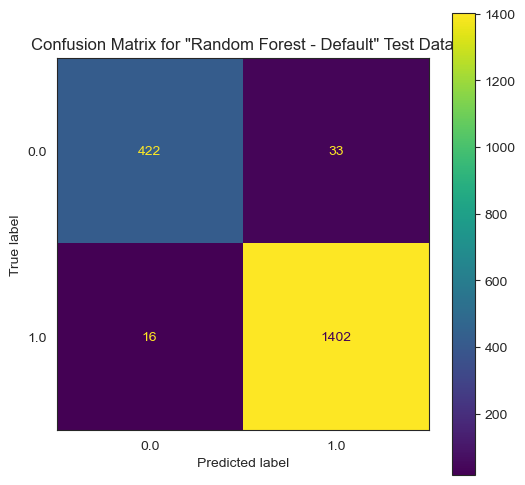

In [271]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month Dow

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [528]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.677089    0.677089           1.0  0.807457   

   train_logloss  test_accuracy  test_prec  test_recall  test_f1  \
0      11.638901          0.675      0.675          1.0  0.80597   

   test_logloss  AUC  
0     11.714187  0.5

In [543]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   6.8s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [544]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   26.2s finished


name  train_accuracy  \
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.935383   
3                              Extra Trees - Default        0.937294   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.921659   
2                            Random Forest - Default        0.922876   
5                           XGBoost - Default Mostly        0.899600   
4                                 AdaBoost - Default        0.769496   
6                      K Nearest Neighbors - Default        0.717906   
1                      Logistic Regression - Default        0.677436   
0                                        Dummy Model        0.677089   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
8    0.947948      0.957157  0.952502       0.221946       0.939063   
3    0.940748      0.968445  0.954371       0.223543       0.934896   
7    0.928514      0.958184  0.943059       0.212111       0.930729   
2    0.926511      0.962545  0.944145       0.248411       0.927083   
5    0.915192      0.938945  0.926799       0.272855       0.919271   
4    0.774759      0.930224  0.845336       0.672888       0.780208   
6    0.767346      0.837357  0.800751       1.590883       0.754687   
1    0.685666      0.966907  0.802326       0.606792       0.675521   
0    0.677089      1.000000  0.807457      11.638901       0.675000   

   test_prec  test_recall   test_f1  test_logloss       AUC  
8   0.949657     0.960648  0.955121      0.224404  0.975737  
3   0.939235     0.966049  0.952453      0.206072  0.976405  
7   0.933632     0.966049  0.949564      0.202390  0.973783  
2   0.930700     0.963735  0.946929      0.249474  0.967304  
5   0.926064     0.956790  0.941176      0.249623  0.962404  
4   0.781935     0.935185  0.851722      0.673175  0.836888  
6   0.789474     0.868056  0.826902      1.488469  0.778742  
1   0.685195     0.960648  0.799872      0.612012  0.625591  
0   0.675000     1.000000  0.805970     11.714187  0.500000

- Log Reg NEAR IDENTICAL!
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [496]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('GDP', 0.10298457945065966),
 ('Interest Rates', 0.09262122055012043),
 ('ATR', 0.06868216177322331),
 ('one_up_bollinger_band', 0.055605912789238744),
 ('upper_bollinger_band', 0.0541691225013223),
 ('lowest_bollinger_band', 0.052545530351708225),
 ('lower_bollinger_band', 0.0521523134603251),
 ('Adj Close', 0.051313808923403495),
 ('20_day_SMA', 0.050822656829984776),
 ('High', 0.04902142694729922),
 ('Low', 0.04705909524862651),
 ('Close', 0.046466307465767576),
 ('MACD', 0.04403405571483964),
 ('RSI', 0.04098577510327467),
 ('Open', 0.040895905170569125),
 ('Volume', 0.02584767645758064),
 ('dollar_volume(M)', 0.025371536152960363),
 ('garman_klass_vol', 0.018147939928177915),
 ('CMA', 0.017258149191161545),
 ('RMW', 0.016781329738436938),
 ('HML', 0.01631265560786329),
 ('SMB', 0.015982131463213416),
 ('Mkt-RF', 0.014938709180243114)]

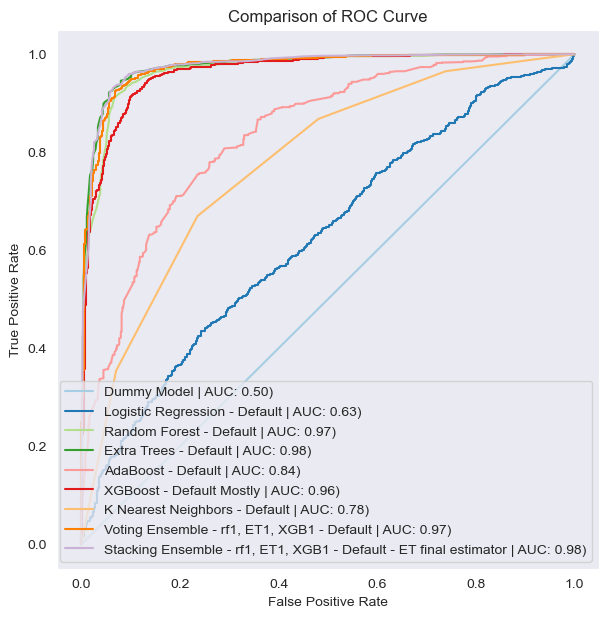

In [546]:
log_reg1.compare_roc_curve()

In [1]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Dow_3_month.csv')

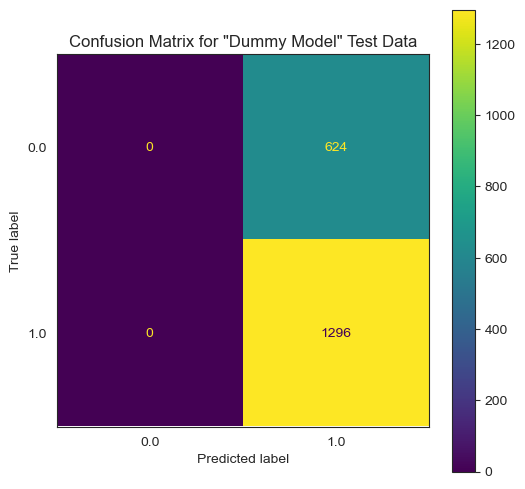

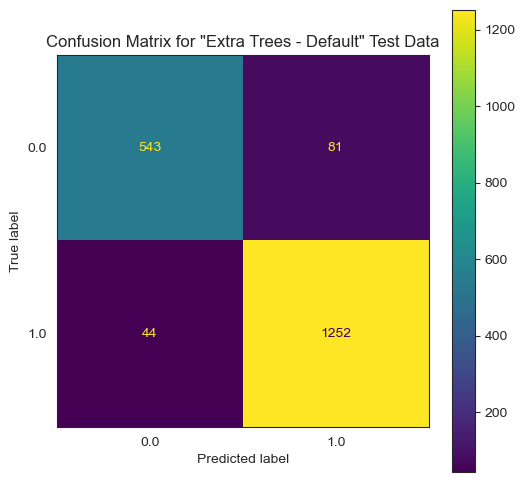

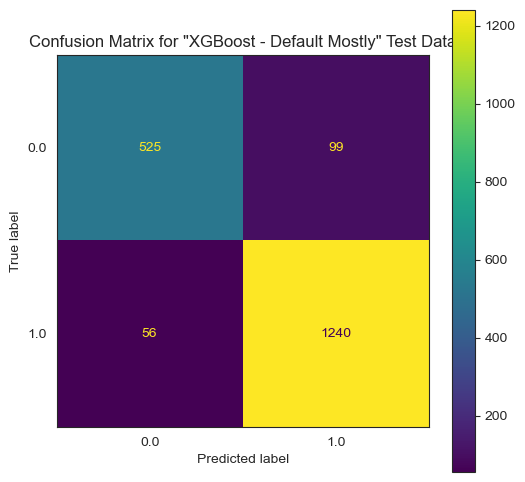

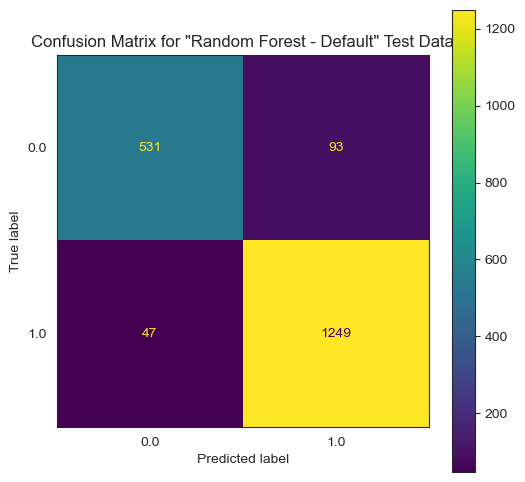

In [499]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month Dow

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [455]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.715812    0.715812           1.0  0.834371   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      10.243188       0.703782   0.703782          1.0  0.826141   

   test_logloss  AUC  
0     10.676796  0.5

In [6]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

In [471]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.0s finished


name  train_accuracy  \
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.953774   
3                              Extra Trees - Default        0.952897   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.951498   
2                            Random Forest - Default        0.949046   
5                           XGBoost - Default Mostly        0.941868   
4                                 AdaBoost - Default        0.834179   
6                      K Nearest Neighbors - Default        0.814391   
1                      Logistic Regression - Default        0.735071   
0                                        Dummy Model        0.715812   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
8    0.963185      0.972603  0.967868       0.164199       0.962710   
3    0.960018      0.974804  0.967352       0.155513       0.959559   
7    0.959279      0.973580  0.966367       0.143980       0.955357   
2    0.955856      0.973826  0.964748       0.173060       0.954832   
5    0.953433      0.965998  0.959665       0.189291       0.945378   
4    0.845271      0.940800  0.890393       0.668134       0.832458   
6    0.844433      0.908024  0.875065       1.128355       0.805147   
1    0.747343      0.951567  0.837173       0.542708       0.722164   
0    0.715812      1.000000  0.834371      10.243188       0.703782   

   test_prec  test_recall   test_f1  test_logloss       AUC  
8   0.966887     0.980597  0.973694      0.118314  0.991685  
3   0.962637     0.980597  0.971534      0.154218  0.990099  
7   0.957695     0.979851  0.968646      0.133613  0.988819  
2   0.954348     0.982836  0.968382      0.182709  0.986117  
5   0.950437     0.973134  0.961652      0.165611  0.982836  
4   0.839654     0.941791  0.887795      0.669149  0.905176  
6   0.832533     0.905224  0.867358      1.046174  0.857934  
1   0.731054     0.957463  0.829079      0.548809  0.719263  
0   0.703782     1.000000  0.826141     10.676796  0.500000

- Log Reg slight improvement
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [472]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('GDP', 0.12843922115869028),
 ('Interest Rates', 0.1061625583968737),
 ('ATR', 0.07055497721658933),
 ('upper_bollinger_band', 0.053087675841188675),
 ('20_day_SMA', 0.0521178553001155),
 ('Adj Close', 0.051931106510838355),
 ('lower_bollinger_band', 0.051385106617562834),
 ('lowest_bollinger_band', 0.0504099866055435),
 ('one_up_bollinger_band', 0.04908832674597109),
 ('Close', 0.04566609068429074),
 ('Open', 0.04454081255574305),
 ('High', 0.043828746309434174),
 ('Low', 0.04194050268230867),
 ('MACD', 0.03736921216680509),
 ('RSI', 0.03116301855645025),
 ('Volume', 0.030497871631205382),
 ('dollar_volume(M)', 0.026816069081419962),
 ('garman_klass_vol', 0.016303736585887345),
 ('CMA', 0.015829872296755615),
 ('RMW', 0.014341045786168152),
 ('HML', 0.013858531542916448),
 ('Mkt-RF', 0.013095448632135465),
 ('SMB', 0.011572227095106575)]

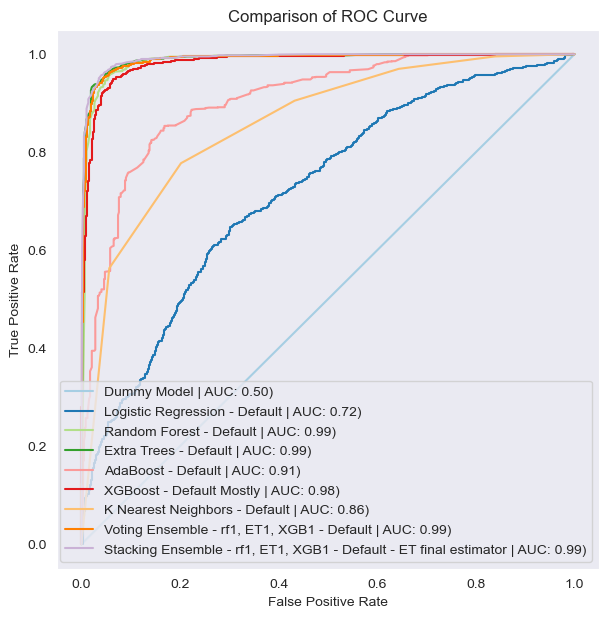

In [473]:
log_reg1.compare_roc_curve()

In [474]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/DOW_6_month.csv')

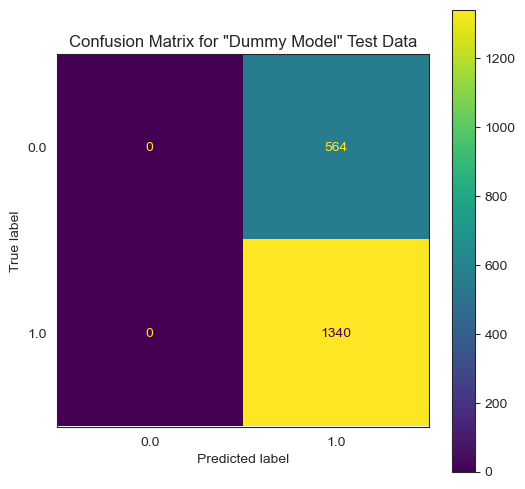

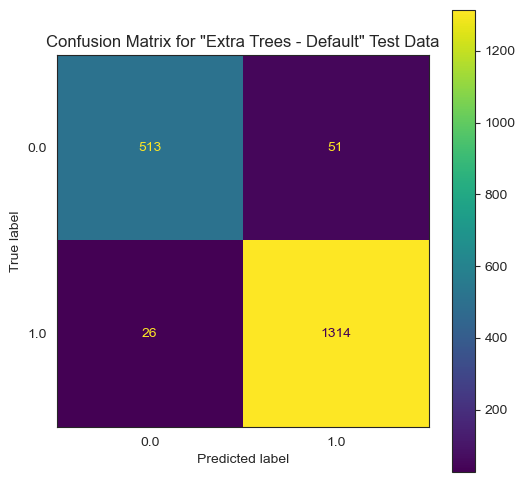

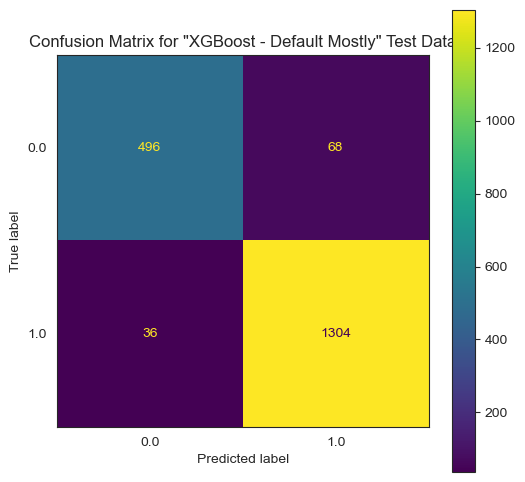

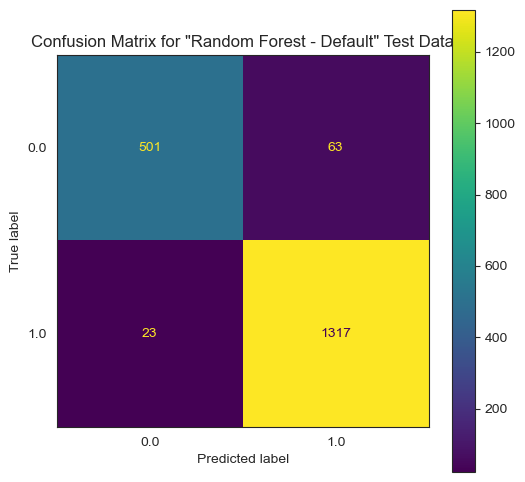

In [475]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 1 Month S&P

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [427]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.636806    0.636806           1.0  0.778108   

   train_logloss  test_accuracy  test_prec  test_recall  test_f1  \
0      13.090855       0.626757   0.626757          1.0  0.77056   

   test_logloss  AUC  
0     13.453045  0.5

In [5]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

In [443]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   30.3s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.893056   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.889583   
2                            Random Forest - Default        0.869444   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.871701   
5                           XGBoost - Default Mostly        0.826042   
4                                 AdaBoost - Default        0.692361   
6                      K Nearest Neighbors - Default        0.654861   
0                                        Dummy Model        0.636806   
1                      Logistic Regression - Default        0.630556   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.898698      0.937849  0.917795       0.306051       0.911504   
8    0.904283      0.924485  0.914260       0.331187       0.910463   
2    0.876366      0.925581  0.900234       0.348163       0.909422   
7    0.878144      0.927213  0.901982       0.322946       0.894326   
5    0.846241      0.888225  0.866699       0.448883       0.852681   
4    0.696672      0.915761  0.791276       0.687221       0.688183   
6    0.703200      0.792272  0.744990       1.798895       0.667361   
0    0.636806      1.000000  0.778108      13.090855       0.626757   
1    0.645947      0.929118  0.762055       0.643833       0.619990   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.915595     0.946013  0.930556      0.265114  0.970498  
8   0.921569     0.936877  0.929160      0.224421  0.968152  
2   0.910686     0.948505  0.929211      0.303153  0.959352  
7   0.896279     0.940199  0.917714      0.279126  0.961246  
5   0.868106     0.901993  0.884725      0.371791  0.916061  
4   0.685697     0.927741  0.788563      0.688241  0.720850  
6   0.704266     0.808970  0.752996      1.664862  0.677608  
0   0.626757     1.000000  0.770560     13.453045  0.500000  
1   0.635894     0.921096  0.752374      0.646977  0.619070

- Log Reg slight improvement
- Extra Trees continues to outperform all other models
- Same Top 3 excluding voting ensembles

### Feature Importances

In [444]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('Interest Rates', 0.0751778387453256),
 ('ATR', 0.06721720265415582),
 ('GDP', 0.057502221365507984),
 ('MACD', 0.055980726658121364),
 ('lowest_bollinger_band', 0.0552003027761901),
 ('upper_bollinger_band', 0.054374597524188856),
 ('20_day_SMA', 0.05411004365304751),
 ('one_up_bollinger_band', 0.05405102556624095),
 ('lower_bollinger_band', 0.053589835098073885),
 ('Close', 0.048727629118783054),
 ('High', 0.04831267885095513),
 ('Adj Close', 0.04815990933156063),
 ('Low', 0.04632283173258916),
 ('RSI', 0.04558494795921516),
 ('Open', 0.04390473734744546),
 ('Volume', 0.032086046234056725),
 ('dollar_volume(M)', 0.03143194286658515),
 ('garman_klass_vol', 0.023676326766034927),
 ('SMB', 0.021304861988124774),
 ('HML', 0.021204746674293503),
 ('CMA', 0.021022857795564374),
 ('Mkt-RF', 0.02082589270729907),
 ('RMW', 0.02023079658664081)]

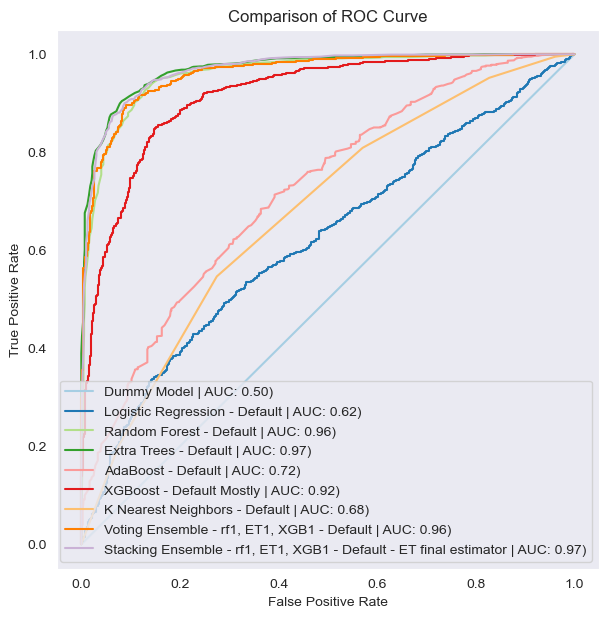

In [445]:
log_reg1.compare_roc_curve()

In [446]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/S&P_1_month.csv')

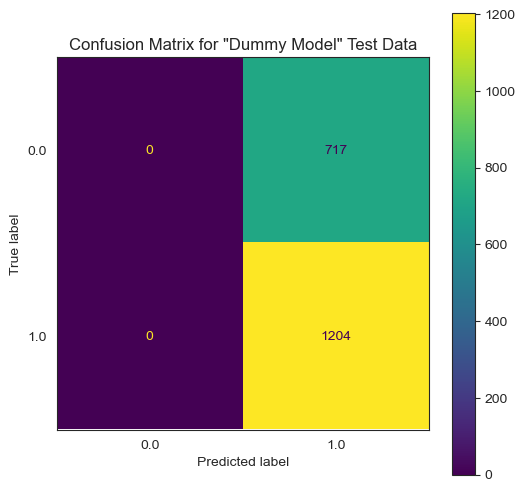

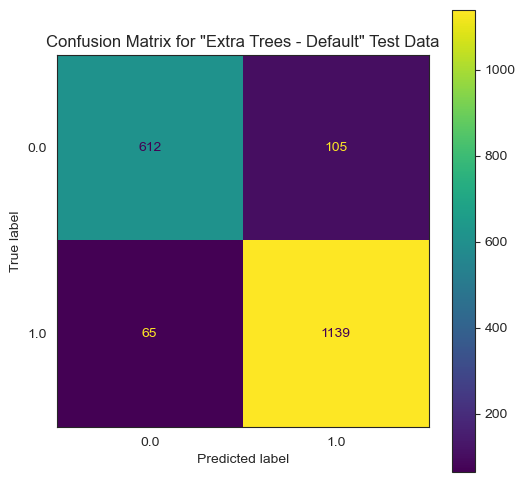

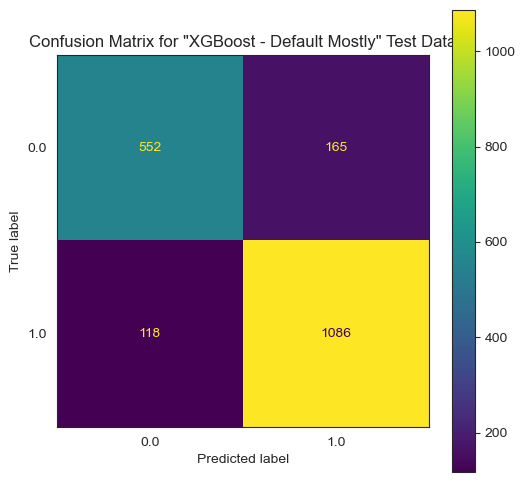

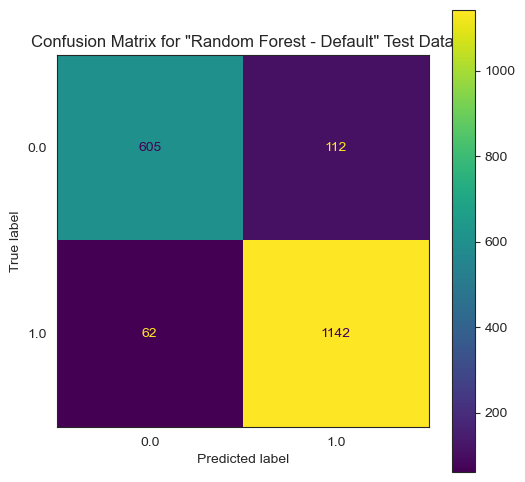

In [447]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month S&P

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [403]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.678826    0.678826           1.0  0.808691   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      11.576292       0.693229   0.693229          1.0  0.818825   

   test_logloss  AUC  
0     11.057142  0.5

In [418]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   6.9s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [419]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   26.8s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.939378   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.939897   
2                            Random Forest - Default        0.926176   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.932256   
5                           XGBoost - Default Mostly        0.915755   
4                                 AdaBoost - Default        0.767759   
6                      K Nearest Neighbors - Default        0.744141   
0                                        Dummy Model        0.678826   
1                      Logistic Regression - Default        0.670491   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.946762      0.964943  0.955753       0.204845       0.946875   
8    0.953636      0.958034  0.955815       0.227516       0.946875   
2    0.932248      0.961106  0.946450       0.232910       0.935417   
7    0.937619      0.964433  0.950814       0.194867       0.934375   
5    0.928742      0.948824  0.938636       0.247211       0.919792   
4    0.776883      0.922976  0.843615       0.678168       0.787500   
6    0.784158      0.860031  0.820309       1.505963       0.761458   
0    0.678826      1.000000  0.808691      11.576292       0.693229   
1    0.691490      0.929122  0.792855       0.602769       0.670312   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.954848     0.969196  0.961969      0.172857  0.985199  
8   0.962378     0.960932  0.961654      0.207376  0.984921  
2   0.944077     0.963937  0.953903      0.213587  0.978424  
7   0.943341     0.963186  0.953160      0.174829  0.981842  
5   0.936249     0.948911  0.942537      0.223572  0.969126  
4   0.786824     0.951165  0.861224      0.678103  0.826108  
6   0.805886     0.864012  0.833938      1.538961  0.772441  
0   0.693229     1.000000  0.818825     11.057142  0.500000  
1   0.703143     0.907588  0.792391      0.602314  0.641804

- Log Reg slight regression in performance from dummy
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [420]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('GDP', 0.10153252124343598),
 ('Interest Rates', 0.09722338218457388),
 ('ATR', 0.07008375140490983),
 ('upper_bollinger_band', 0.05616592930319251),
 ('one_up_bollinger_band', 0.05471779157107166),
 ('lowest_bollinger_band', 0.05379989044342172),
 ('20_day_SMA', 0.052457492441877994),
 ('MACD', 0.04987911045683982),
 ('lower_bollinger_band', 0.049749296774159485),
 ('Adj Close', 0.0490586574794614),
 ('Close', 0.0445182676344921),
 ('High', 0.04418067574353182),
 ('Open', 0.044095465741532607),
 ('Low', 0.042852962188033486),
 ('RSI', 0.038284615502963394),
 ('dollar_volume(M)', 0.029986809262363846),
 ('Volume', 0.029471450391779203),
 ('garman_klass_vol', 0.017202172496201974),
 ('HML', 0.015507645672616898),
 ('CMA', 0.015464504466521593),
 ('RMW', 0.014952273946607126),
 ('Mkt-RF', 0.014500145133911834),
 ('SMB', 0.014315188516499992)]

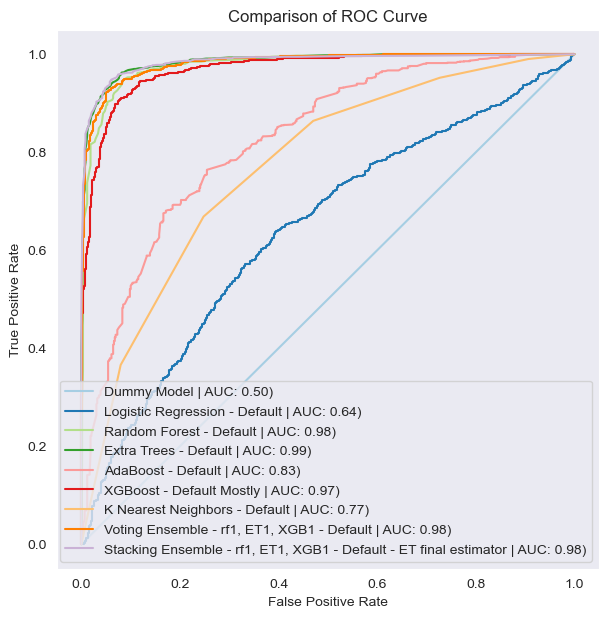

In [421]:
log_reg1.compare_roc_curve()

In [422]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/S&P_3_month.csv')

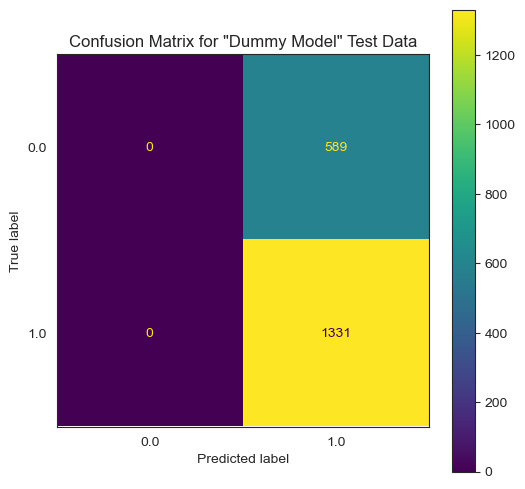

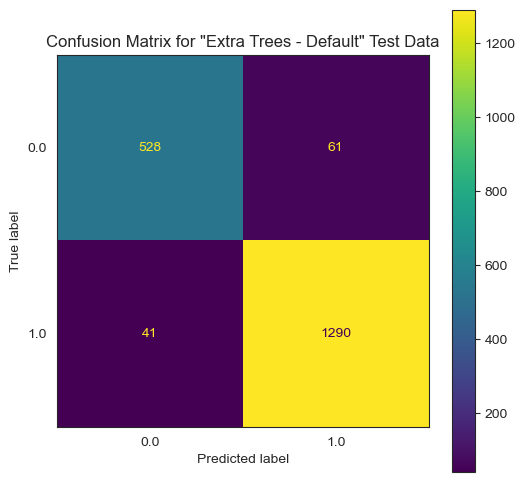

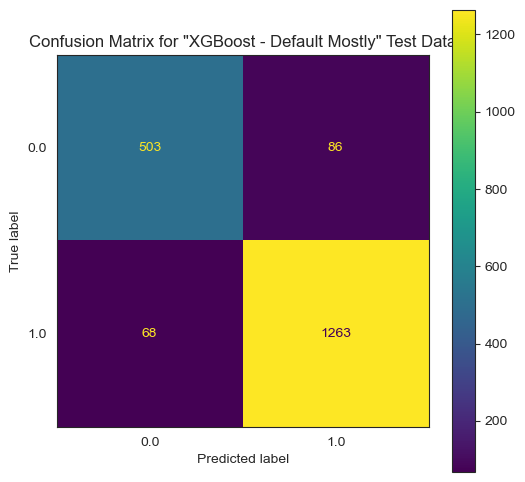

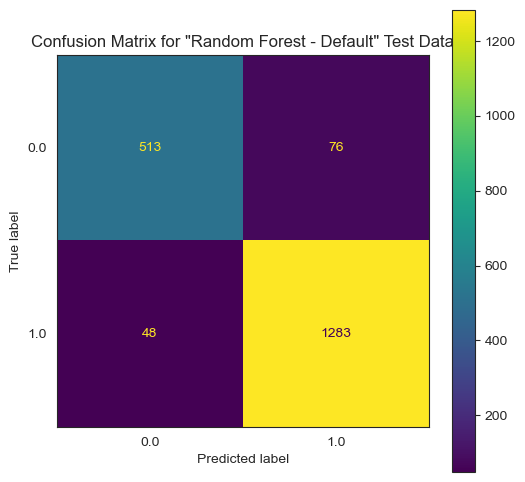

In [423]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month S&P

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [375]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.724392    0.724392           1.0  0.840171   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0       9.933936       0.719013   0.719013          1.0  0.836541   

   test_logloss  AUC  
0     10.127812  0.5

In [4]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

In [393]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# NN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

name  train_accuracy  \
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.969882   
2                            Random Forest - Default        0.965155   
3                              Extra Trees - Default        0.970582   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.967080   
5                           XGBoost - Default Mostly        0.961828   
4                                 AdaBoost - Default        0.861319   
6                      K Nearest Neighbors - Default        0.824899   
1                      Logistic Regression - Default        0.727194   
0                                        Dummy Model        0.724392   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
8    0.976462      0.982115  0.979271       0.153245       0.976366   
2    0.968384      0.984048  0.976142       0.135845       0.975840   
3    0.974221      0.985498  0.979815       0.129637       0.975840   
7    0.972960      0.981872  0.977385       0.107414       0.975315   
5    0.969138      0.978488  0.973782       0.136800       0.966912   
4    0.862256      0.962537  0.909556       0.661001       0.866071   
6    0.857925      0.909111  0.882720       1.043793       0.830357   
1    0.749295      0.936912  0.832656       0.538567       0.721639   
0    0.724392      1.000000  0.840171       9.933936       0.719013   

   test_prec  test_recall   test_f1  test_logloss       AUC  
8   0.983212     0.983930  0.983571      0.070737  0.995520  
2   0.980392     0.986121  0.983248      0.118549  0.994728  
3   0.979695     0.986852  0.983261      0.113385  0.994950  
7   0.978292     0.987582  0.982915      0.093096  0.994413  
5   0.973875     0.980278  0.977066      0.109180  0.991420  
4   0.882030     0.939372  0.909798      0.664262  0.930197  
6   0.860690     0.911614  0.885420      1.007973  0.868332  
1   0.742626     0.937911  0.828922      0.540870  0.731386  
0   0.719013     1.000000  0.836541     10.127812  0.500000

- Log Reg nearly identical
- EXTRA TREES/RANDOM FOREST TIED THE LEAD FOR FIRST TIME!!!!
- Same Top 3

### Feature Importances

In [394]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('GDP', 0.14140042121894353),
 ('Interest Rates', 0.1174858830682047),
 ('ATR', 0.07362244047017989),
 ('upper_bollinger_band', 0.06265839771905424),
 ('one_up_bollinger_band', 0.05397293119043064),
 ('20_day_SMA', 0.04984336301121013),
 ('lowest_bollinger_band', 0.04911661539894021),
 ('High', 0.04849593385839383),
 ('lower_bollinger_band', 0.04797350493347597),
 ('Adj Close', 0.046697743826757086),
 ('Open', 0.04283971298882782),
 ('Close', 0.04207034349865804),
 ('Low', 0.038188403674775454),
 ('MACD', 0.032544490122047326),
 ('Volume', 0.028821439694008907),
 ('dollar_volume(M)', 0.028462941060782957),
 ('RSI', 0.026166004864004083),
 ('RMW', 0.013433970637787045),
 ('garman_klass_vol', 0.013231647994150855),
 ('CMA', 0.012451792355677158),
 ('HML', 0.011364818158031914),
 ('Mkt-RF', 0.010068632042029029),
 ('SMB', 0.009088568213629127)]

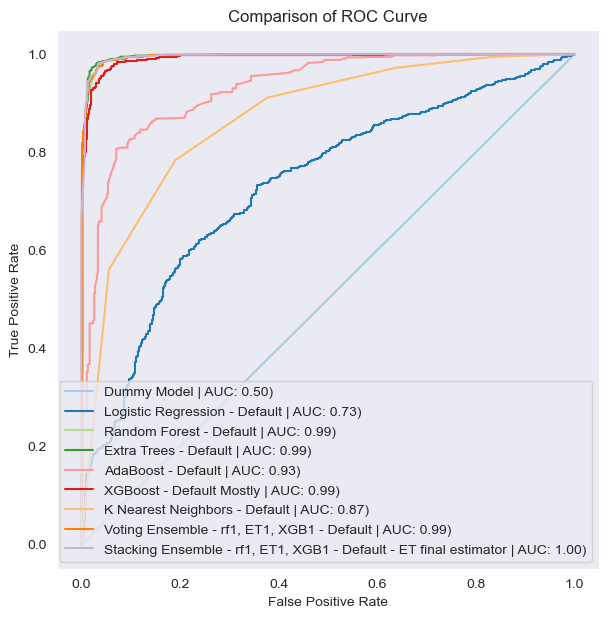

In [395]:
log_reg1.compare_roc_curve()

In [3]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/S&P_6_month.csv')

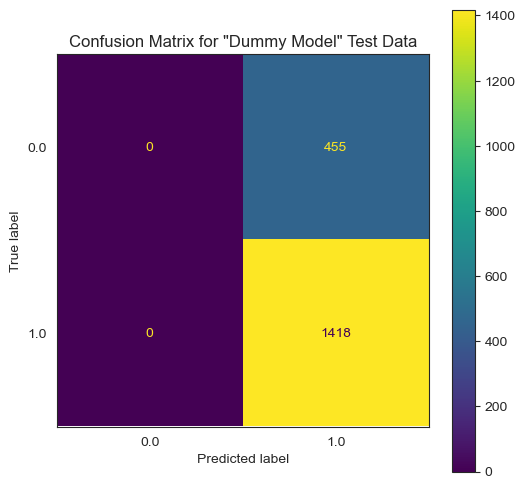

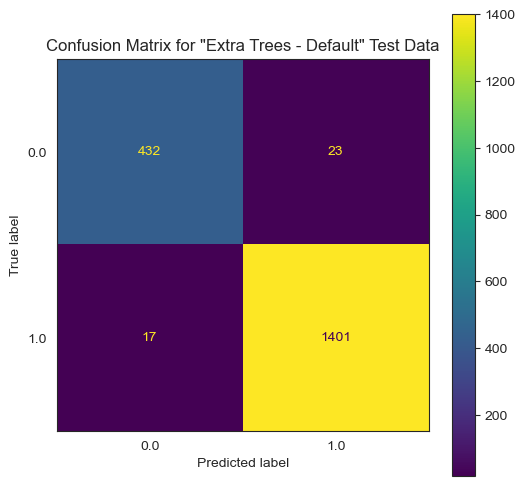

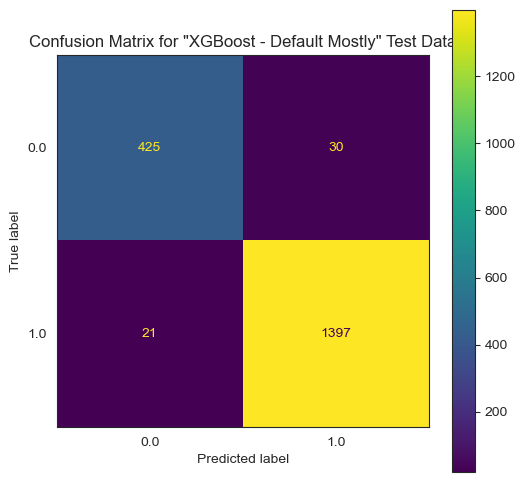

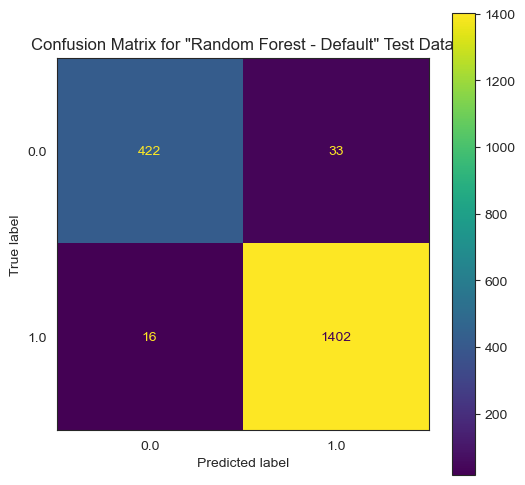

In [271]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 12 Month S&P

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [351]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.774653    0.774653           1.0  0.873019   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0       8.122332       0.754939   0.754939          1.0  0.860359   

   test_logloss  AUC  
0      8.832908  0.5

In [366]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   5.2s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [367]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   20.0s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.983802   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.983802   
2                            Random Forest - Default        0.980064   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.980955   
5                           XGBoost - Default Mostly        0.976326   
4                                 AdaBoost - Default        0.942151   
6                      K Nearest Neighbors - Default        0.896049   
1                      Logistic Regression - Default        0.816840   
0                                        Dummy Model        0.774653   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.987648      0.991500  0.989565       0.068156       0.975974   
8    0.989434      0.989661  0.989543       0.073450       0.974907   
2    0.983144      0.991270  0.987183       0.079793       0.974373   
7    0.984038      0.991500  0.987752       0.060081       0.974373   
5    0.980647      0.988972  0.984784       0.077717       0.971169   
4    0.946826      0.980470  0.963318       0.645136       0.936466   
6    0.917272      0.951750  0.934167       0.709558       0.888414   
1    0.835774      0.950369  0.889367       0.420058       0.794447   
0    0.774653      1.000000  0.873019       8.122332       0.754939   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.979678     0.988685  0.984161      0.107969  0.993335  
8   0.978307     0.988685  0.983468      0.111925  0.993675  
2   0.974965     0.991513  0.983170      0.127936  0.992347  
7   0.975627     0.990806  0.983158      0.074349  0.993868  
5   0.974198     0.987977  0.981039      0.100761  0.991918  
4   0.935440     0.983734  0.958980      0.653423  0.971086  
6   0.903550     0.954031  0.928105      0.917833  0.918266  
1   0.809009     0.952617  0.874959      0.453259  0.785438  
0   0.754939     1.000000  0.860359      8.832908  0.500000

- Log Reg slight improvement
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [368]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('GDP', 0.1367684958101326),
 ('Interest Rates', 0.1341562767770929),
 ('ATR', 0.06787077460394059),
 ('upper_bollinger_band', 0.06011290336961489),
 ('20_day_SMA', 0.05908980821995585),
 ('lowest_bollinger_band', 0.057493374691151004),
 ('lower_bollinger_band', 0.05491342125668016),
 ('one_up_bollinger_band', 0.054031102411741944),
 ('Adj Close', 0.04715438898987439),
 ('High', 0.044396726699992214),
 ('Close', 0.04436665433427866),
 ('Low', 0.04077611021215068),
 ('Open', 0.03858197901648292),
 ('dollar_volume(M)', 0.03082014596430232),
 ('RSI', 0.02623654770278675),
 ('MACD', 0.026226164216610278),
 ('Volume', 0.02469804113633094),
 ('RMW', 0.01112622488658511),
 ('CMA', 0.010477516714571491),
 ('garman_klass_vol', 0.009098126609972328),
 ('HML', 0.008418658842535436),
 ('SMB', 0.006742808460216482),
 ('Mkt-RF', 0.006443749073000152)]

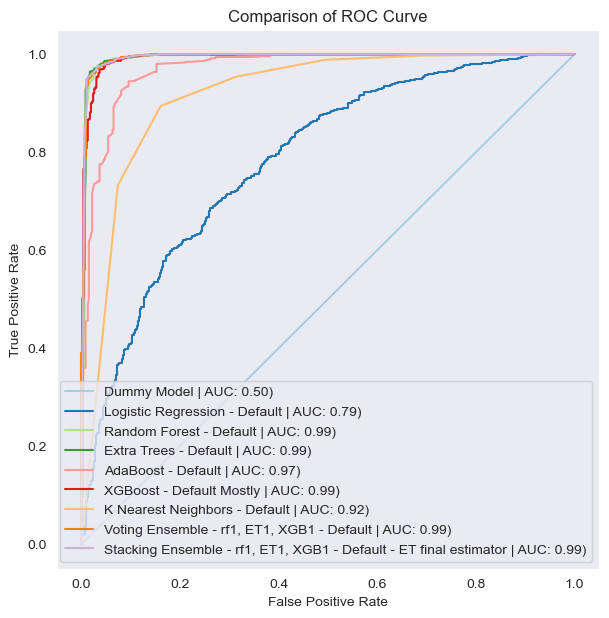

In [369]:
log_reg1.compare_roc_curve()

In [370]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/S&P_12_month.csv')

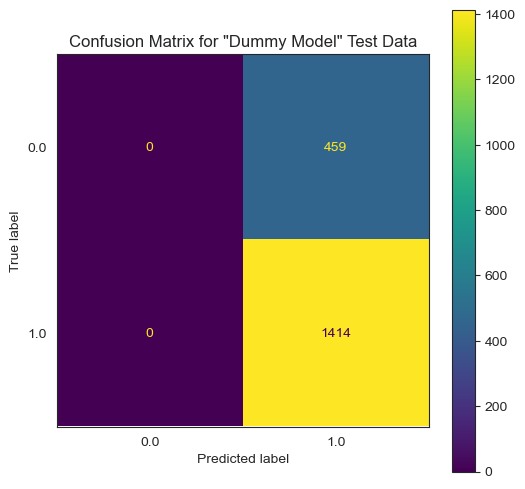

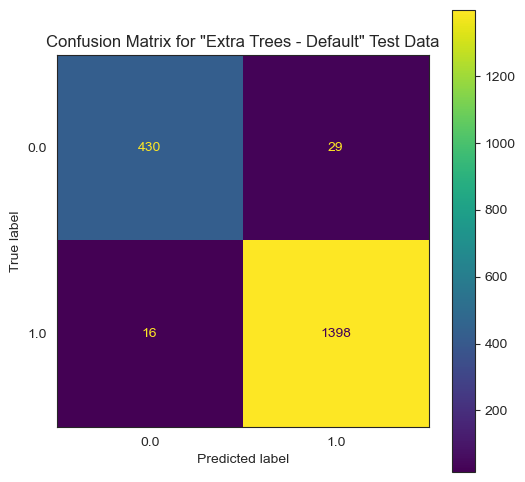

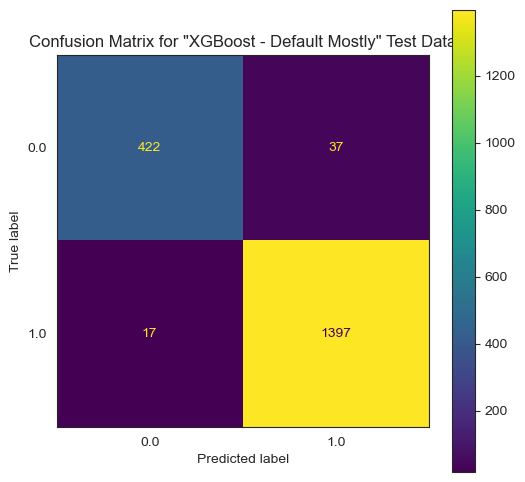

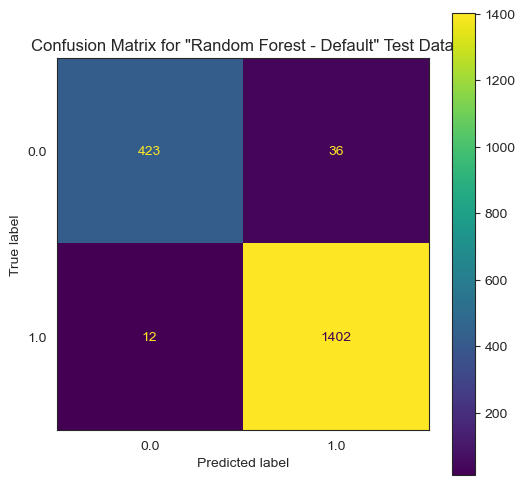

In [371]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 1 Month Nasdaq

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [326]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.626389    0.626389           1.0  0.770282   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      13.466309       0.634045   0.634045          1.0  0.776043   

   test_logloss  AUC  
0     13.190364  0.5

In [341]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   8.0s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [347]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

name  train_accuracy  \
3                              Extra Trees - Default        0.911285   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.914236   
2                            Random Forest - Default        0.888194   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.884549   
5                           XGBoost - Default Mostly        0.832812   
4                                 AdaBoost - Default        0.683333   
6                      K Nearest Neighbors - Default        0.635764   
0                                        Dummy Model        0.626389   
1                      Logistic Regression - Default        0.627951   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.918433      0.942074  0.930090       0.301597       0.918792   
8    0.925914      0.938194  0.931990       0.297658       0.916189   
2    0.890870      0.936257  0.912975       0.355387       0.907860   
7    0.887409      0.934314  0.910225       0.311430       0.902655   
5    0.849526      0.891079  0.869749       0.438390       0.847996   
4    0.685702      0.912963  0.783099       0.686641       0.680375   
6    0.682663      0.782157  0.728976       1.898393       0.653826   
0    0.626389      1.000000  0.770282      13.466309       0.634045   
1    0.635927      0.949837  0.761800       0.653534       0.634045   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.931006     0.941708  0.936327      0.252846  0.970757  
8   0.929326     0.939245  0.934259      0.232512  0.968662  
2   0.911462     0.946634  0.928715      0.305969  0.959455  
7   0.912730     0.935961  0.924199      0.276268  0.960781  
5   0.873387     0.889163  0.881204      0.387524  0.912225  
4   0.688986     0.903941  0.781960      0.687714  0.666497  
6   0.699639     0.795567  0.744526      1.662701  0.659118  
0   0.634045     1.000000  0.776043     13.190364  0.500000  
1   0.642030     0.955665  0.768063      0.648779  0.579444

- Log Reg nearly identical
- Extra Trees continues to outperform all other models, MORE FALSE NEGATIVES, still good precision
- Same Top 3

### Feature Importances

In [343]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('Interest Rates', 0.08125066035308094),
 ('ATR', 0.06645833795794757),
 ('GDP', 0.06515596905708486),
 ('one_up_bollinger_band', 0.0580311600242244),
 ('upper_bollinger_band', 0.05713430453764935),
 ('lower_bollinger_band', 0.056923785603122834),
 ('20_day_SMA', 0.056075882922707966),
 ('lowest_bollinger_band', 0.05602443407786412),
 ('MACD', 0.055890417885154704),
 ('Close', 0.04577962437125265),
 ('High', 0.045645275546346065),
 ('RSI', 0.04527073781501204),
 ('Adj Close', 0.04513363543248586),
 ('Low', 0.04339134054471386),
 ('Open', 0.04256133987529874),
 ('dollar_volume(M)', 0.02913125986898002),
 ('Volume', 0.02825127664275727),
 ('garman_klass_vol', 0.022939703890688796),
 ('RMW', 0.02073626117401684),
 ('HML', 0.01987501451730946),
 ('SMB', 0.019821647570843776),
 ('Mkt-RF', 0.01949803895645901),
 ('CMA', 0.01901989137499898)]

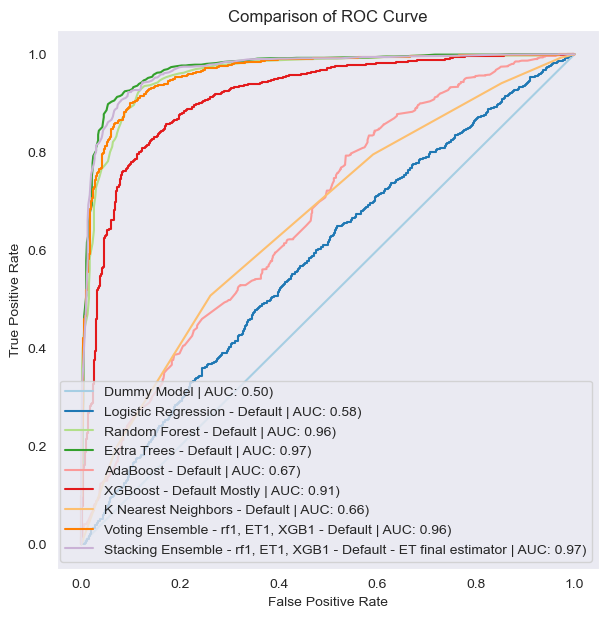

In [344]:
log_reg1.compare_roc_curve()

In [345]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/NASDAQ_1_month.csv')

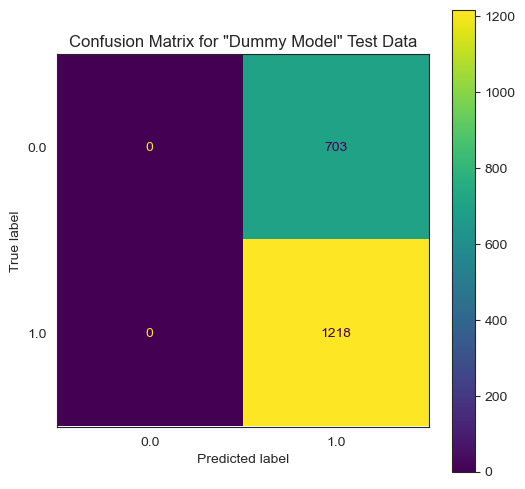

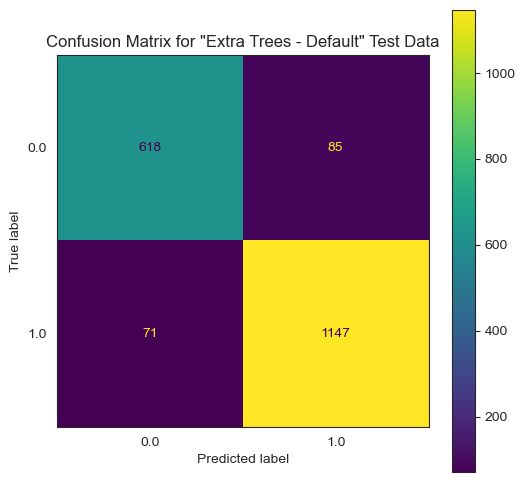

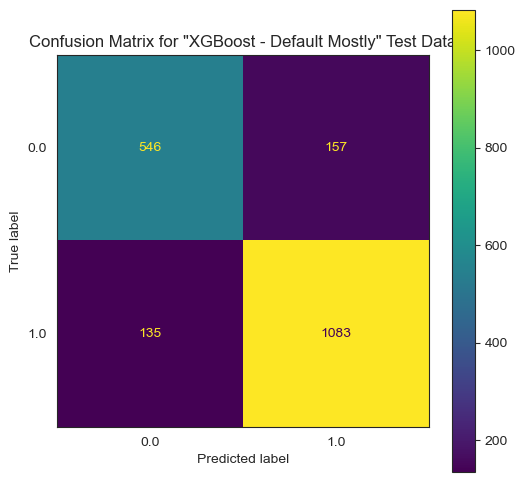

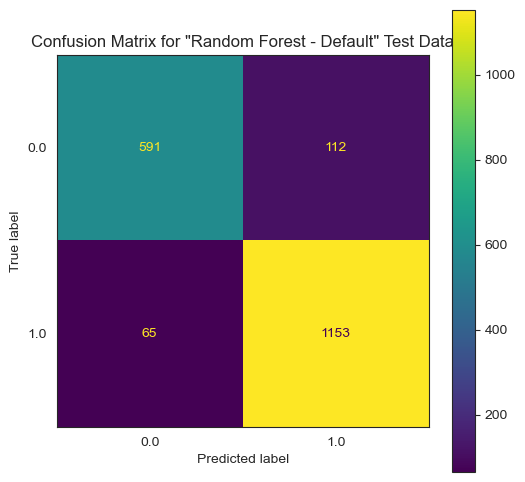

In [346]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month Nasdaq

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [302]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.675352    0.675352           1.0  0.806221   

   train_logloss  test_accuracy  test_prec  test_recall  test_f1  \
0      11.701509       0.680729   0.680729          1.0  0.81004   

   test_logloss  AUC  
0     11.507687  0.5

In [317]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   7.1s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [318]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   28.0s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.951885   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.952060   
2                            Random Forest - Default        0.943200   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.945980   
5                           XGBoost - Default Mostly        0.923050   
4                                 AdaBoost - Default        0.767412   
6                      K Nearest Neighbors - Default        0.732674   
0                                        Dummy Model        0.675352   
1                      Logistic Regression - Default        0.682126   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.953121      0.976851  0.964829       0.195433       0.952083   
8    0.959109      0.970423  0.964723       0.192270       0.952083   
2    0.942073      0.976082  0.958728       0.214874       0.941667   
7    0.946373      0.975309  0.960617       0.180876       0.938021   
5    0.929880      0.958334  0.943885       0.234590       0.928646   
4    0.766791      0.942128  0.845449       0.678594       0.770312   
6    0.768319      0.865227  0.813848       1.681389       0.735938   
0    0.675352      1.000000  0.806221      11.701509       0.680729   
1    0.696894      0.936730  0.799193       0.603801       0.670312   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.956424     0.973986  0.965125      0.185540  0.984531  
8   0.962681     0.967100  0.964885      0.198289  0.984689  
2   0.944899     0.970926  0.957736      0.195059  0.980531  
7   0.940653     0.970161  0.955179      0.169558  0.983428  
5   0.937220     0.959449  0.948204      0.206566  0.972264  
4   0.776148     0.931140  0.846609      0.679114  0.816173  
6   0.771370     0.869931  0.817691      1.666817  0.732525  
0   0.680729     1.000000  0.810040     11.507687  0.500000  
1   0.695023     0.918898  0.791433      0.613639  0.614365

- Log Reg slightly worse on test data
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [319]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('GDP', 0.11406928705595763),
 ('Interest Rates', 0.10771693318520009),
 ('ATR', 0.07880707138680919),
 ('upper_bollinger_band', 0.05327926469062193),
 ('one_up_bollinger_band', 0.05257679917351641),
 ('MACD', 0.05106193583459373),
 ('lowest_bollinger_band', 0.050204037647350916),
 ('20_day_SMA', 0.050128112297515945),
 ('lower_bollinger_band', 0.04809840360995302),
 ('Adj Close', 0.04367011999551529),
 ('High', 0.04317395183069614),
 ('Close', 0.04214926518948941),
 ('RSI', 0.04074037833633262),
 ('Open', 0.03916265052116609),
 ('Low', 0.03851604486130226),
 ('dollar_volume(M)', 0.02957526584199084),
 ('Volume', 0.028963575960521546),
 ('garman_klass_vol', 0.01702461202722424),
 ('RMW', 0.015305410855526376),
 ('HML', 0.014745710209354794),
 ('CMA', 0.014195744191644691),
 ('SMB', 0.013576950611319884),
 ('Mkt-RF', 0.013258474686397006)]

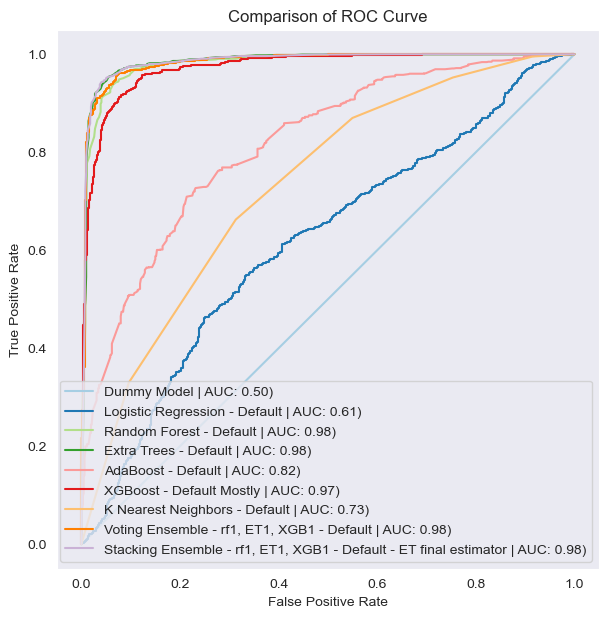

In [320]:
log_reg1.compare_roc_curve()

In [321]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/NASDAQ_3_month.csv')

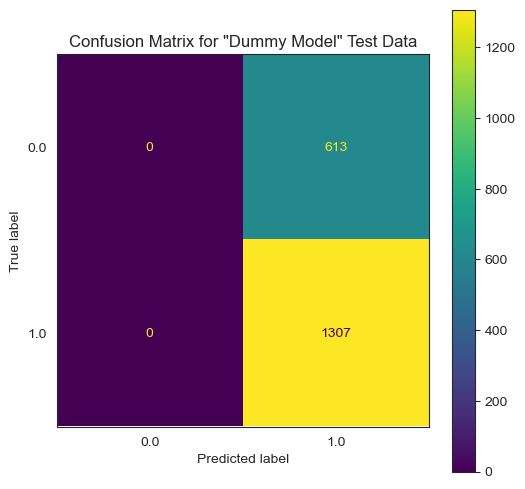

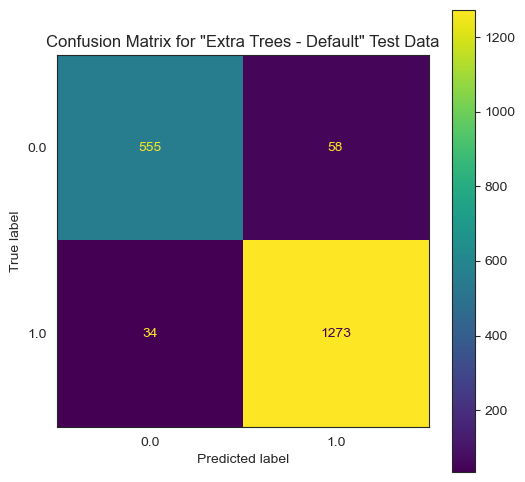

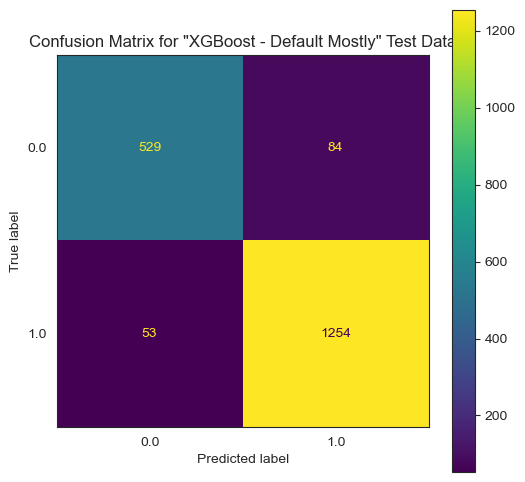

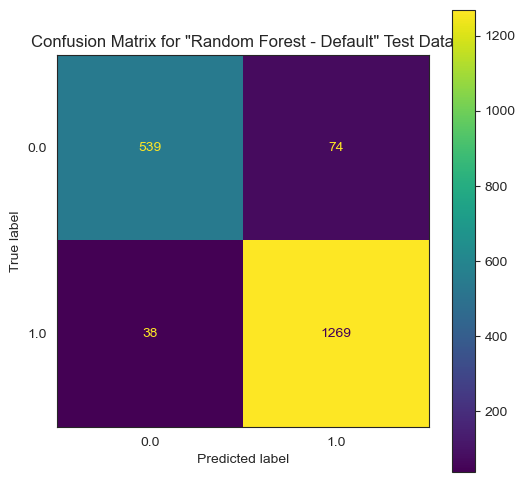

In [322]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month Nasdaq

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [276]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model         0.71371     0.71371           1.0  0.832942   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      10.318925       0.707983   0.707983          1.0  0.829028   

   test_logloss  AUC  
0     10.525353  0.5

In [292]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   6.0s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [293]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.8s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.973034   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.973908   
2                            Random Forest - Default        0.966729   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.968655   
5                           XGBoost - Default Mostly        0.962876   
4                                 AdaBoost - Default        0.861144   
6                      K Nearest Neighbors - Default        0.818419   
1                      Logistic Regression - Default        0.763790   
0                                        Dummy Model        0.713710   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.975077      0.987487  0.981228       0.121253       0.973214   
8    0.978799      0.984788  0.981776       0.115282       0.972164   
2    0.967618      0.986506  0.976937       0.138200       0.969538   
7    0.970137      0.986506  0.978239       0.105776       0.969013   
5    0.966285      0.982334  0.974223       0.120955       0.965861   
4    0.858285      0.964915  0.908424       0.659091       0.860819   
6    0.843147      0.916093  0.878084       1.154328       0.804622   
1    0.772772      0.947745  0.851349       0.529575       0.752626   
0    0.713710      1.000000  0.832942      10.318925       0.707983   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.977189     0.985163  0.981160      0.103452  0.994517  
8   0.981413     0.979228  0.980319      0.139827  0.993031  
2   0.972182     0.985163  0.978629      0.118888  0.992792  
7   0.972854     0.983680  0.978237      0.099347  0.994071  
5   0.970653     0.981454  0.976024      0.118969  0.990544  
4   0.851852     0.972552  0.908209      0.657411  0.930777  
6   0.827517     0.914688  0.868922      1.056339  0.844895  
1   0.760237     0.950297  0.844708      0.548037  0.688605  
0   0.707983     1.000000  0.829028     10.525353  0.500000

- Log Reg slight improvement
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [294]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('GDP', 0.1399767891196926),
 ('Interest Rates', 0.12179883445147632),
 ('ATR', 0.08059675605345014),
 ('upper_bollinger_band', 0.05761556187753545),
 ('20_day_SMA', 0.055061504514291856),
 ('one_up_bollinger_band', 0.05401525402182541),
 ('lower_bollinger_band', 0.05015331202685202),
 ('lowest_bollinger_band', 0.049268661947593946),
 ('Adj Close', 0.04425524005719952),
 ('Open', 0.043404909203994126),
 ('Low', 0.041817927744758565),
 ('High', 0.040838597205407313),
 ('Close', 0.0399303325807068),
 ('MACD', 0.03794753506528858),
 ('Volume', 0.02695967052389801),
 ('RSI', 0.026575321627874886),
 ('dollar_volume(M)', 0.024051378919801317),
 ('garman_klass_vol', 0.01483882507778695),
 ('CMA', 0.012000780376918284),
 ('RMW', 0.010708428644584685),
 ('HML', 0.00997804693910608),
 ('Mkt-RF', 0.009227195415976431),
 ('SMB', 0.008979136603980704)]

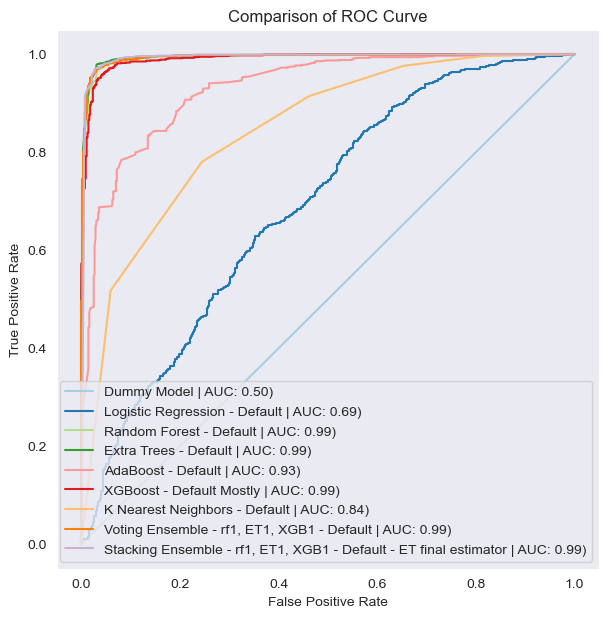

In [295]:
log_reg1.compare_roc_curve()

In [296]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/NASDAQ_6_month.csv')

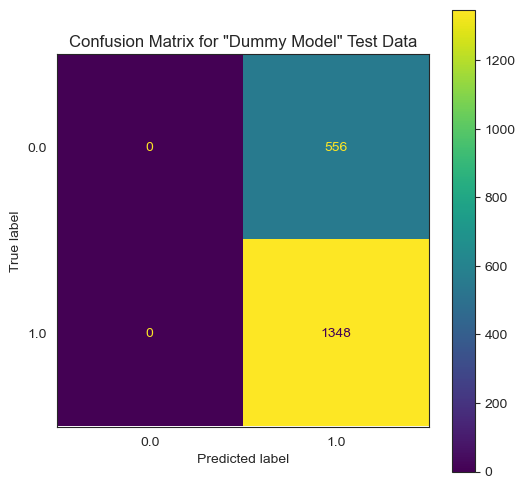

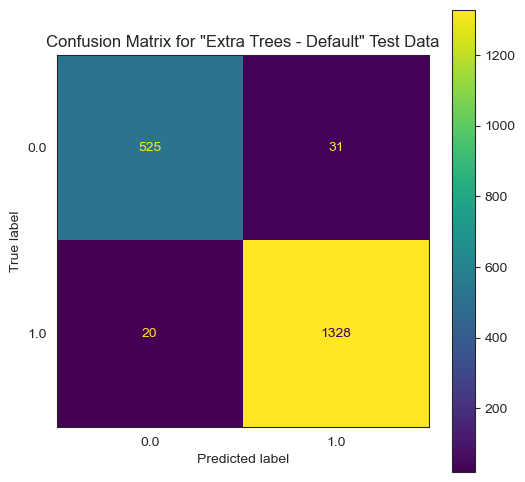

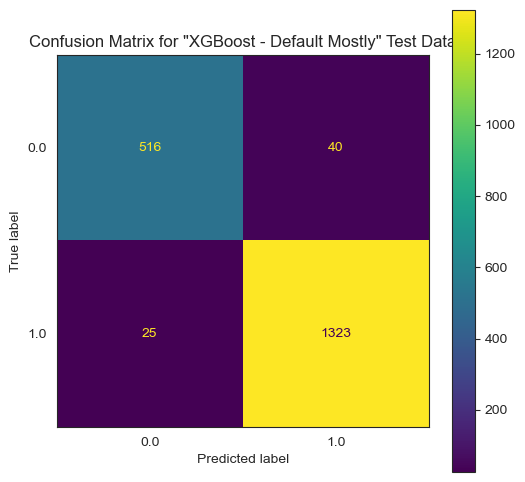

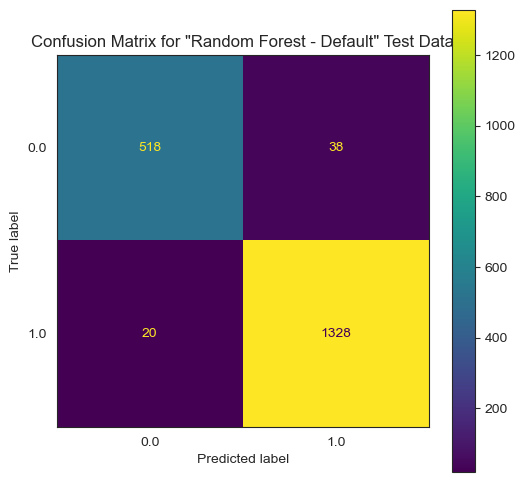

In [297]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 12 Month Nasdaq

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [224]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.761659    0.761659           1.0  0.864706   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0        8.59068       0.757074   0.757074          1.0  0.861744   

   test_logloss  AUC  
0      8.755933  0.5

In [240]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   5.5s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [267]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

name  train_accuracy  \
3                              Extra Trees - Default        0.981133   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.976683   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.980955   
2                            Random Forest - Default        0.974725   
5                           XGBoost - Default Mostly        0.970986   
4                                 AdaBoost - Default        0.915984   
6                      K Nearest Neighbors - Default        0.882167   
1                      Logistic Regression - Default        0.827875   
0                                        Dummy Model        0.761659   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.983348      0.992054  0.987671       0.080967       0.978644   
7    0.979693      0.989951  0.984778       0.075002       0.977042   
8    0.985824      0.989249  0.987522       0.085492       0.977042   
2    0.975454      0.991821  0.983554       0.093270       0.973839   
5    0.976898      0.985276  0.981044       0.106383       0.972771   
4    0.914276      0.981771  0.946811       0.658358       0.905499   
6    0.896196      0.956067  0.925134       0.946514       0.873999   
1    0.831469      0.970790  0.895743       0.444928       0.808329   
0    0.761659      1.000000  0.864706       8.590680       0.757074   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.983848     0.988011  0.985925      0.074303  0.995892  
7   0.979763     0.990127  0.984918      0.070286  0.996148  
8   0.985180     0.984485  0.984832      0.054121  0.997618  
2   0.977003     0.988717  0.982825      0.083379  0.995015  
5   0.978977     0.985190  0.982074      0.088744  0.992925  
4   0.907955     0.973907  0.939775      0.654914  0.966216  
6   0.894000     0.945698  0.919123      0.895122  0.902164  
1   0.816497     0.963329  0.883856      0.461983  0.747219  
0   0.757074     1.000000  0.861744      8.755933  0.500000

- Log Reg slight improvement
- Extra Trees continues to outperform all other models
- Same Top 3

### Feature Importances

In [266]:
# Extracting feature importances/coefficients

sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)

[('Interest Rates', 0.14143174422843213),
 ('GDP', 0.12846575098079852),
 ('ATR', 0.07983517114108377),
 ('upper_bollinger_band', 0.058069486222676624),
 ('20_day_SMA', 0.05347823530783958),
 ('one_up_bollinger_band', 0.051393259218582434),
 ('lowest_bollinger_band', 0.048624154233849325),
 ('lower_bollinger_band', 0.04826763495941984),
 ('Open', 0.047990992794191265),
 ('Close', 0.04397051458719087),
 ('High', 0.043679650721400516),
 ('Low', 0.04344551197964775),
 ('Adj Close', 0.039947265904996566),
 ('dollar_volume(M)', 0.03394445081747598),
 ('Volume', 0.030771238100399223),
 ('MACD', 0.029713236884021412),
 ('RSI', 0.02171733139066293),
 ('garman_klass_vol', 0.011763287553773026),
 ('RMW', 0.011651402627987799),
 ('CMA', 0.010831385791826),
 ('HML', 0.007500936277855356),
 ('SMB', 0.006816795239405197),
 ('Mkt-RF', 0.006690563036484105)]

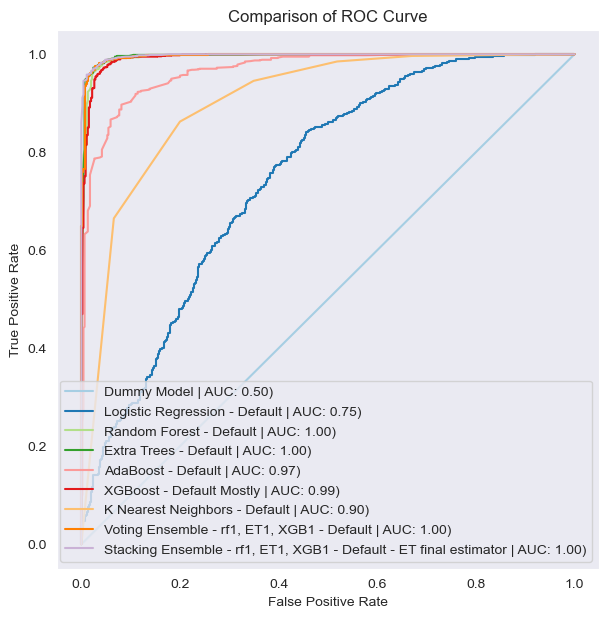

In [269]:
log_reg1.compare_roc_curve()

In [270]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/NASDAQ_12_month.csv')

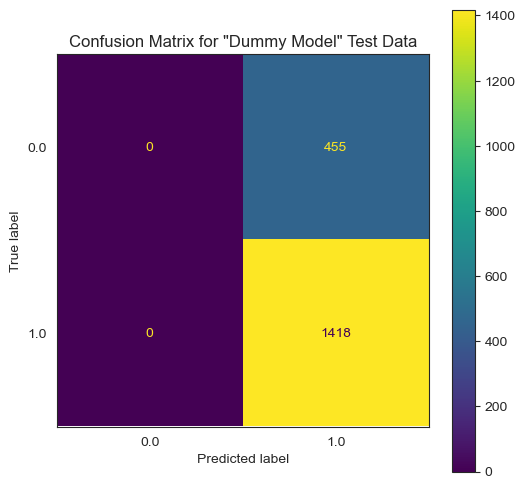

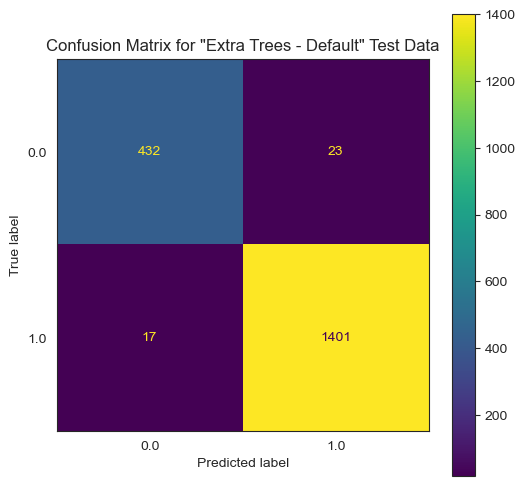

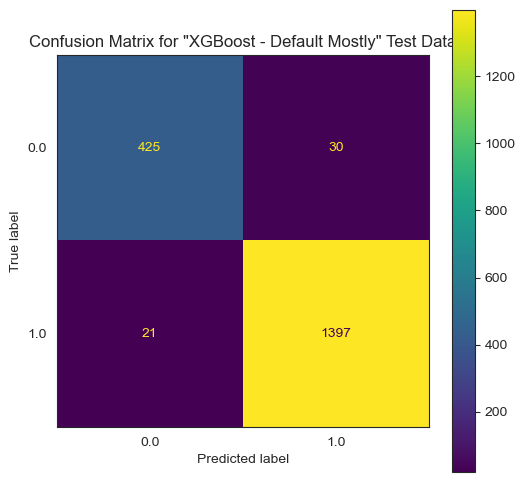

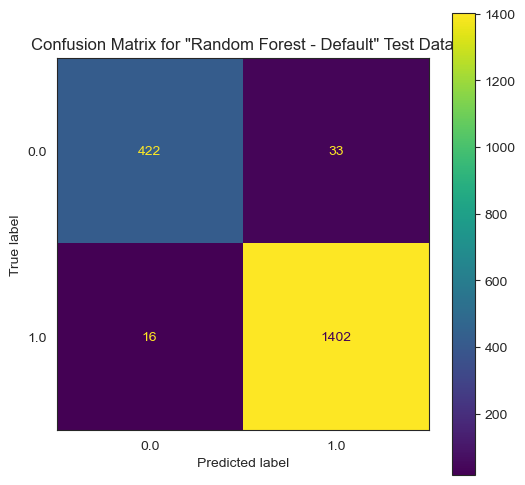

In [271]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 1 Month Russell

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [195]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model         0.60434     0.60434           1.0  0.753382   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      14.261022       0.609578   0.609578          1.0  0.757439   

   test_logloss  AUC  
0     14.072223  0.5

In [210]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.3s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   7.9s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [211]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   31.0s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.892014   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.889931   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.871528   
2                            Random Forest - Default        0.868750   
5                           XGBoost - Default Mostly        0.829167   
4                                 AdaBoost - Default        0.663889   
6                      K Nearest Neighbors - Default        0.616840   
0                                        Dummy Model        0.604340   
1                      Logistic Regression - Default        0.602083   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.899803      0.924445  0.911855       0.318787       0.903696   
8    0.902861      0.916693  0.909637       0.312585       0.902655   
7    0.875152      0.918701  0.896309       0.329750       0.883915   
2    0.873554      0.915544  0.893993       0.367423       0.874024   
5    0.842237      0.882793  0.861999       0.445298       0.839667   
4    0.661804      0.907784  0.765490       0.685937       0.658511   
6    0.663382      0.742899  0.700797       1.819271       0.638209   
0    0.604340      1.000000  0.753382      14.261022       0.609578   
1    0.609808      0.948581  0.742354       0.663387       0.606976   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.909468     0.935098  0.922105      0.283857  0.964000  
8   0.916244     0.924851  0.920527      0.275380  0.961974  
7   0.886623     0.928266  0.906967      0.300592  0.952532  
2   0.878566     0.920581  0.899083      0.334978  0.944626  
5   0.859883     0.880444  0.870042      0.394587  0.910834  
4   0.662461     0.896670  0.761974      0.685026  0.682171  
6   0.682796     0.759180  0.718965      1.557780  0.656377  
0   0.609578     1.000000  0.757439     14.072223  0.500000  
1   0.616592     0.939368  0.744501      0.655679  0.606310

### Log Reg nearly identical to dummy, slightly worse on test
### Extra Trees continues to outperform all other models

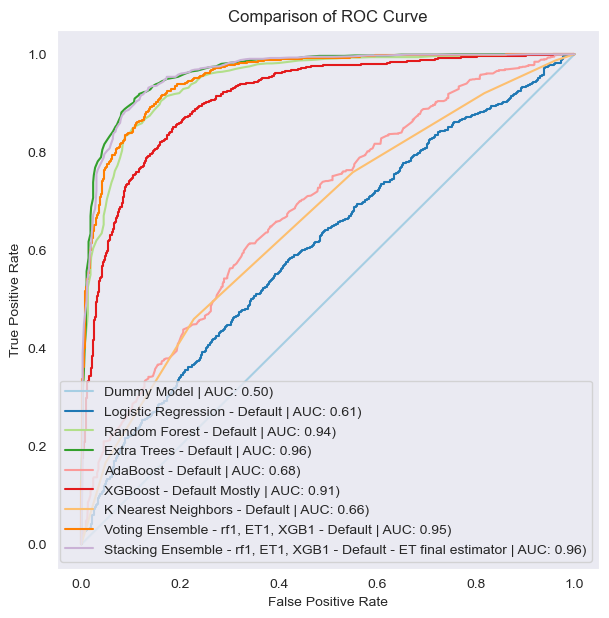

In [212]:
log_reg1.compare_roc_curve()

In [213]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/RUSSELL_1_month.csv')

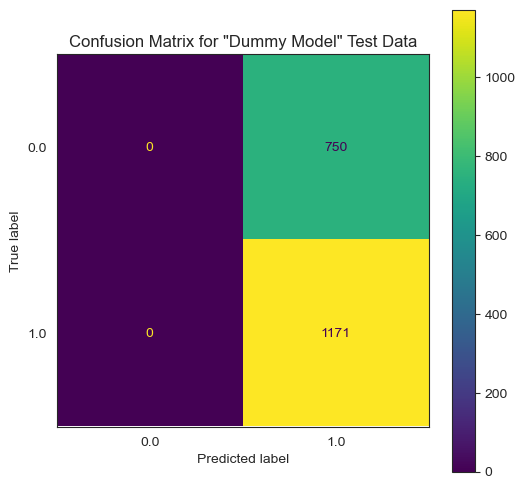

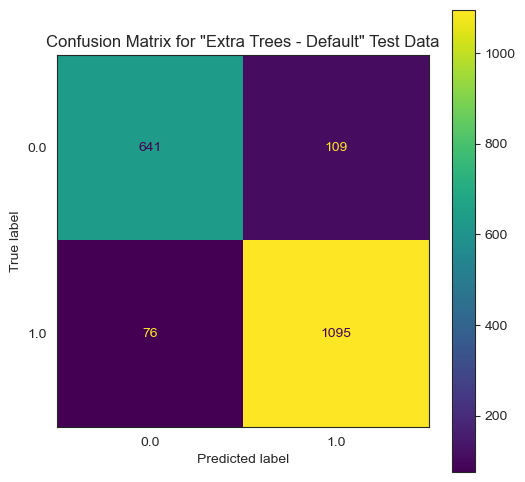

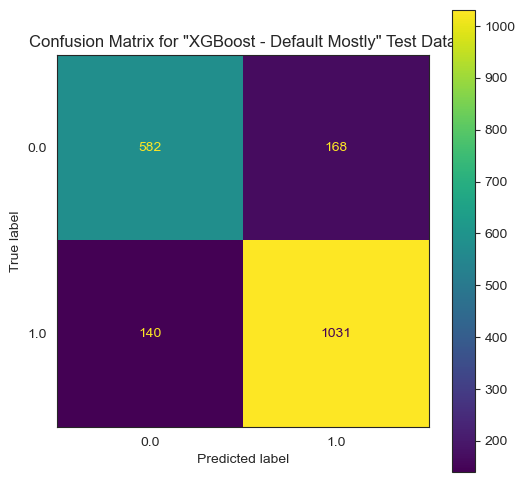

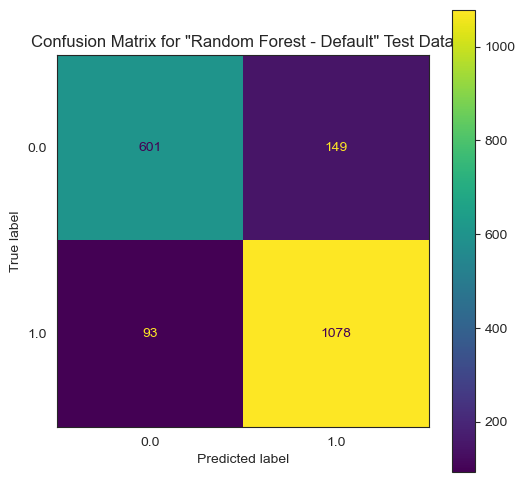

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   1.6s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.4s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.9s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.8s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.8s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s
[Pipel

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   1.5s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.6s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.5s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.9s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.8s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.4s
[Pipel

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   1.5s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.4s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.8s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.8s
[Pipel

In [214]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month Russell

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [172]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.626889    0.626889           1.0   0.77066   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      13.448281       0.636458   0.636458          1.0  0.777849   

   test_logloss  AUC  
0      13.10337  0.5

In [187]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   7.1s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(n_jobs=4,
                                                                                       random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardSca...
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(n_jobs=4,
                                                                                          random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [188]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   27.4s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.937295   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.939205   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.928611   
2                            Random Forest - Default        0.925311   
5                           XGBoost - Default Mostly        0.902556   
4                                 AdaBoost - Default        0.736670   
6                      K Nearest Neighbors - Default        0.697067   
1                      Logistic Regression - Default        0.653988   
0                                        Dummy Model        0.626889   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.944783      0.955943  0.950303       0.213996       0.938021   
8    0.954045      0.948737  0.951368       0.215837       0.938021   
7    0.934352      0.953169  0.943632       0.208688       0.930729   
2    0.931427      0.950953  0.941060       0.245258       0.930208   
5    0.911049      0.935989  0.923323       0.255655       0.914062   
4    0.737385      0.901362  0.811005       0.686306       0.745313   
6    0.737382      0.802712  0.768588       1.564949       0.697396   
1    0.657215      0.936549  0.772378       0.632462       0.661458   
0    0.626889      1.000000  0.770660      13.448281       0.636458   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.953164     0.949264  0.951210      0.210597  0.981939  
8   0.959967     0.941899  0.950847      0.206484  0.982117  
7   0.943043     0.948445  0.945736      0.194358  0.979001  
2   0.942276     0.948445  0.945351      0.227362  0.974148  
5   0.936416     0.927987  0.932182      0.242212  0.965799  
4   0.753633     0.891162  0.816648      0.686360  0.800445  
6   0.747873     0.791326  0.768986      1.503059  0.737667  
1   0.670441     0.920622  0.775862      0.626282  0.655132  
0   0.636458     1.000000  0.777849     13.103370  0.500000

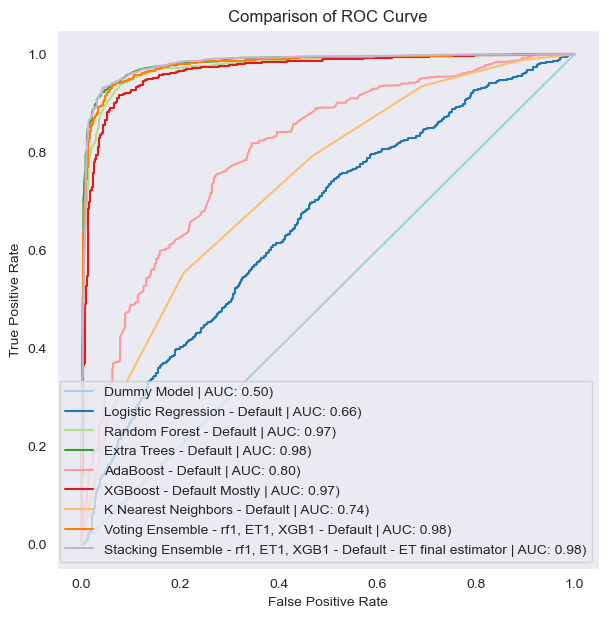

In [189]:
log_reg1.compare_roc_curve()

In [190]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/RUSSELL_3_month.csv')

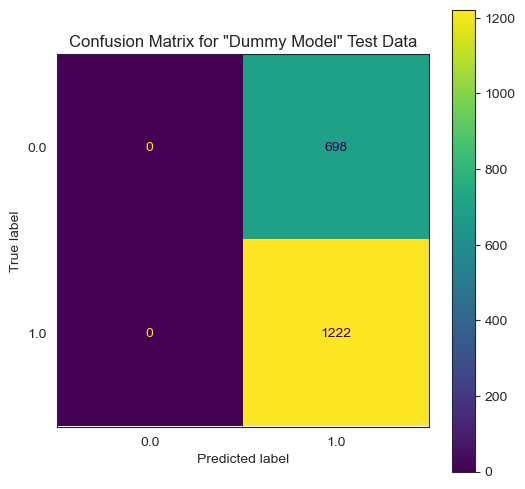

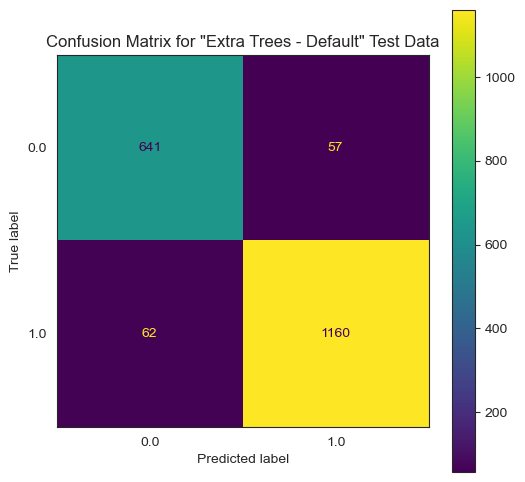

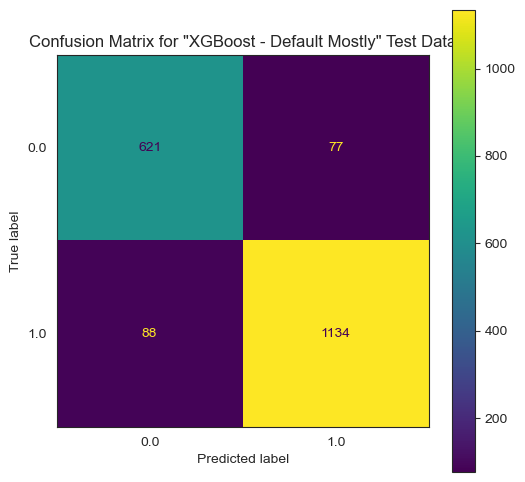

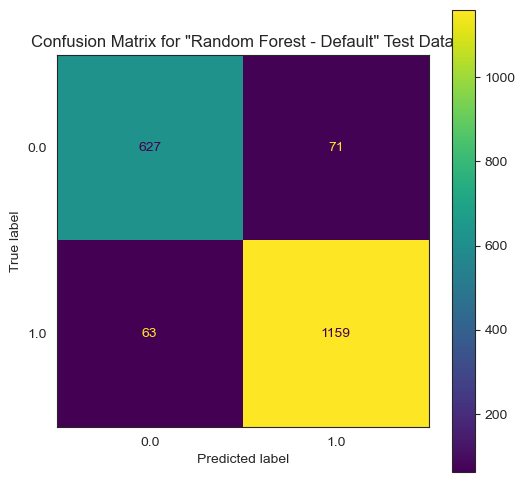

In [191]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month Russell

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [144]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.649799    0.649799           1.0  0.787731   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      12.622538       0.650735   0.650735          1.0  0.788419   

   test_logloss  AUC  
0     12.588776  0.5

In [160]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=4, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.4s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   6.6s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('...
                                                                                max_delta_step=None,
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [161]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.0s finished


name  train_accuracy  \
3                              Extra Trees - Default        0.949570   
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.950096   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.942742   
2                            Random Forest - Default        0.935038   
5                           XGBoost - Default Mostly        0.931361   
4                                 AdaBoost - Default        0.813167   
6                      K Nearest Neighbors - Default        0.761689   
1                      Logistic Regression - Default        0.687796   
0                                        Dummy Model        0.649799   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
3    0.957989      0.964699  0.961332       0.180903       0.965336   
8    0.965264      0.957693  0.961452       0.179787       0.963235   
7    0.949765      0.962813  0.956241       0.166496       0.959559   
2    0.941570      0.959581  0.950479       0.211784       0.959034   
5    0.941495      0.953653  0.947524       0.200627       0.951155   
4    0.818342      0.915929  0.864322       0.669034       0.813025   
6    0.793463      0.856105  0.823585       1.437478       0.775210   
1    0.689708      0.944489  0.797234       0.599940       0.699580   
0    0.649799      1.000000  0.787731      12.622538       0.650735   

   test_prec  test_recall   test_f1  test_logloss       AUC  
3   0.968825     0.978208  0.973494      0.147208  0.992163  
8   0.967974     0.975787  0.971865      0.139236  0.990800  
7   0.962580     0.975787  0.969138      0.136318  0.991485  
2   0.966265     0.970944  0.968599      0.165037  0.989125  
5   0.959135     0.966102  0.962606      0.157343  0.982531  
4   0.821559     0.910412  0.863706      0.670042  0.882729  
6   0.802386     0.868442  0.834109      1.166992  0.827686  
1   0.700300     0.941082  0.803030      0.587220  0.693339  
0   0.650735     1.000000  0.788419     12.588776  0.500000

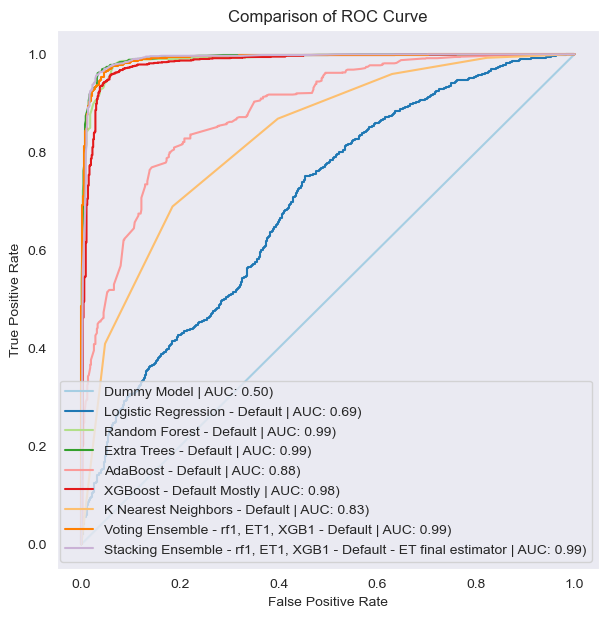

In [162]:
log_reg1.compare_roc_curve()

In [2]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/RUSSELL_6_month.csv')

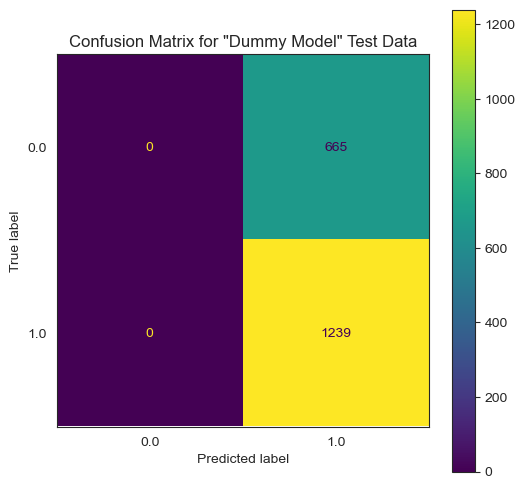

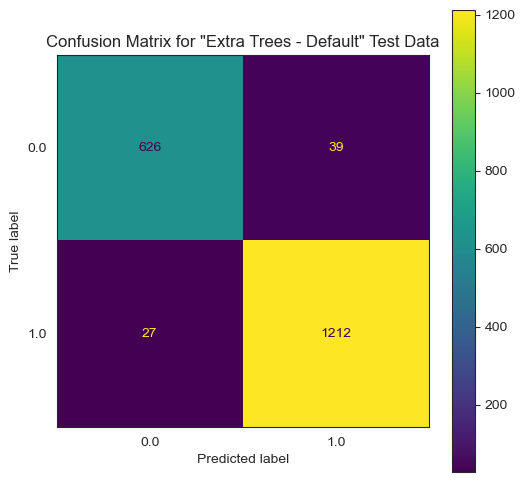

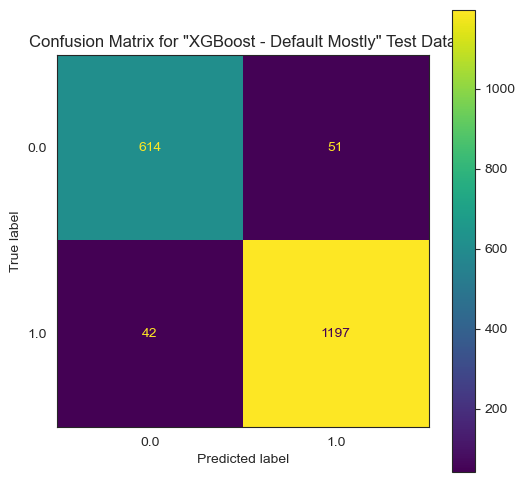

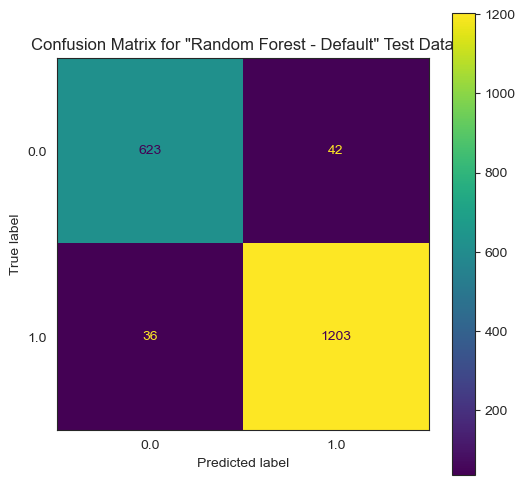

In [164]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 12 Month Russell

### Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [108]:
# Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


In [109]:
Model.model_df

name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.679601    0.679601           1.0  0.809241   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      11.548343       0.663107   0.663107          1.0  0.797432   

   test_logloss  AUC  
0     12.142843  0.5

In [130]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


    # VotingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

    # StackingClassifier(estimators=[
#         ('et', ET1.model),
#         ('rf', rf1.model),
#         ('xg', XGB1.model)
#     ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)


pipeline = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', StackingClassifier(estimators=[
        ('et', ET1.model),
        ('rf', rf1.model),
        ('xg', XGB1.model)
    ], final_estimator=ET1.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)),
], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.4s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   5.5s


Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 StackingClassifier(estimators=[('et',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  ExtraTreesClassifier(random_state=13))],
                                                          verbose=True)),
                                                ('rf',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('lr',
                                                                  RandomForestClassifier(n_jobs=4,
                                                                                         random_state=13))],
                                                          verbose=True)),
                                                ('xg',
                                                 Pipeline(steps=[('ss',
                                                                  StandardScaler()),
                                                                 ('...
                                                                                max_delta_step=None,
                                                                                max_depth=None,
                                                                                max_leaves=0,
                                                                                min_child_weight=None,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                n_estimators=50,
                                                                                n_jobs=4,
                                                                                num_parallel_tree=None,
                                                                                predictor=None,
                                                                                random_state=13, ...))],
                                                          verbose=True))],
                                    final_estimator=Pipeline(steps=[('ss',
                                                                     StandardScaler()),
                                                                    ('lr',
                                                                     ExtraTreesClassifier(random_state=13))],
                                                             verbose=True),
                                    n_jobs=4, passthrough=True))],
         verbose=True)

In [131]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression - Default", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest - Default", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees - Default", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost - Default", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost - Default Mostly", pipeline, X_train, X_test, y_train, y_test)
# KNN = Model("K Nearest Neighbors - Default", pipeline, X_train, X_test, y_train, y_test)
# voting = Model("Voting Ensemble - rf1, ET1, XGB1 - Default", pipeline, X_train, X_test, y_train, y_test)
# stacking = Model("Stacking Ensemble - rf1, ET1, XGB1 - Default - ET final estimator", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   21.5s finished


name  train_accuracy  \
8  Stacking Ensemble - rf1, ET1, XGB1 - Default -...        0.974367   
3                              Extra Trees - Default        0.972587   
7         Voting Ensemble - rf1, ET1, XGB1 - Default        0.970986   
2                            Random Forest - Default        0.965466   
5                           XGBoost - Default Mostly        0.965646   
4                                 AdaBoost - Default        0.917763   
6                      K Nearest Neighbors - Default        0.841224   
1                      Logistic Regression - Default        0.779639   
0                                        Dummy Model        0.679601   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
8    0.980140      0.982189  0.981160       0.091750       0.972237   
3    0.976838      0.982973  0.979893       0.095874       0.970635   
7    0.976048      0.981403  0.978711       0.090144       0.967966   
2    0.970650      0.978782  0.974699       0.114425       0.965296   
5    0.973363      0.976165  0.974761       0.108952       0.963695   
4    0.928493      0.952858  0.940351       0.653166       0.911372   
6    0.864471      0.908852  0.886076       0.912614       0.848905   
1    0.776946      0.947884  0.853927       0.494731       0.773091   
0    0.679601      1.000000  0.809241      11.548343       0.663107   

   test_prec  test_recall   test_f1  test_logloss       AUC  
8   0.976000     0.982287  0.979133      0.101463  0.995450  
3   0.974420     0.981481  0.977938      0.092013  0.996751  
7   0.970541     0.981481  0.975981      0.088785  0.996122  
2   0.967434     0.980676  0.974010      0.121889  0.994859  
5   0.969600     0.975845  0.972713      0.111528  0.993406  
4   0.913846     0.956522  0.934697      0.656679  0.961479  
6   0.864085     0.916264  0.889410      1.078920  0.901931  
1   0.761022     0.958937  0.848593      0.507738  0.789606  
0   0.663107     1.000000  0.797432     12.142843  0.500000

# Notes on models for 12 Month Russell
- log_reg1 11% increase in test accuracy, so significant improvement over dummy, still not competitive generally
- rf1 MASSIVE performance improvements in every statistical category up to 96% acc
- ET1 Extra Trees Default performed even slightly better than RandomForest, best individual model
- AdaBoost is better than Logistic Regression and dummy, but worse than Extra/Random/XGB
- XGBoost also very good 3rd
- KNN is a definite step down from the boosted/tree classifiers
- Voting Ensemble (RF, XG, ET) basically inline with the other tree ensemble methods, EXTRA TREES still best
- Stacking ensemble, FWIW, has an AUC of 1, best overall model

### Both ensembles and ET possess AUC of 1, and also still no overfitting

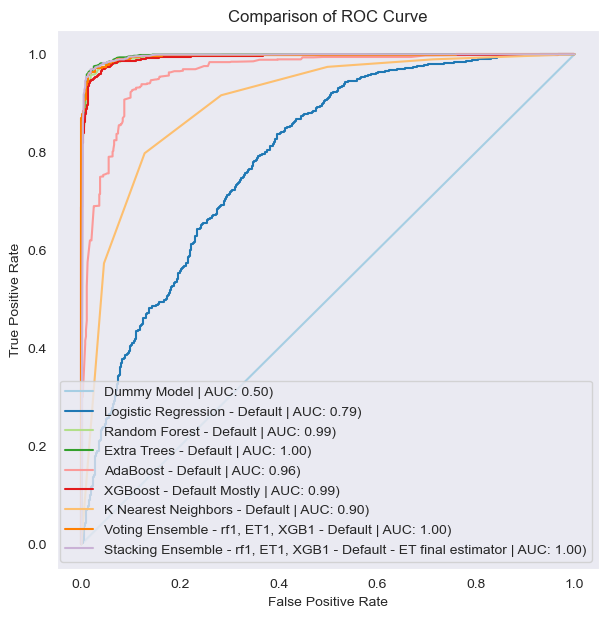

In [138]:
log_reg1.compare_roc_curve()

In [134]:
# Saving File

# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/RUSSELL_12_month.csv')

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   1.2s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.5s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.4s
[Pipel

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   1.2s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.4s
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.3s
[Pipel

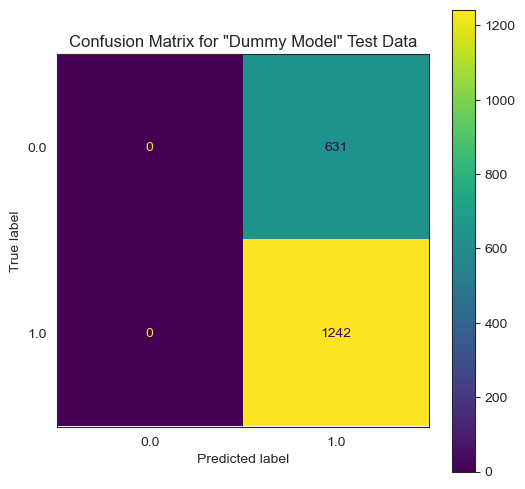

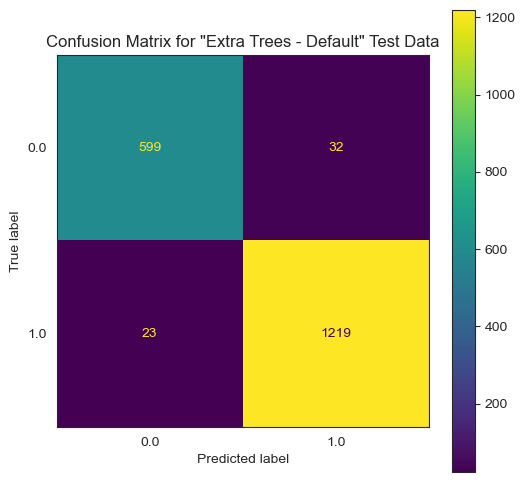

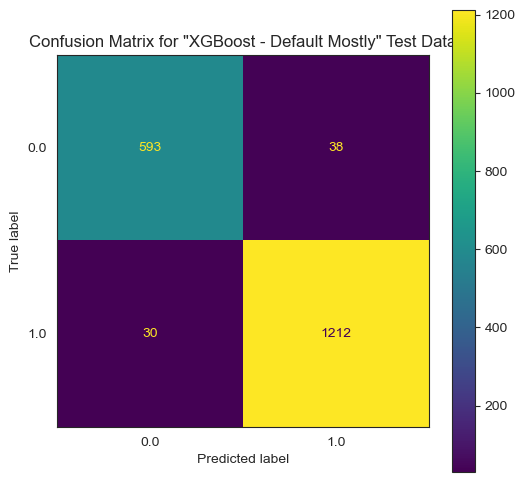

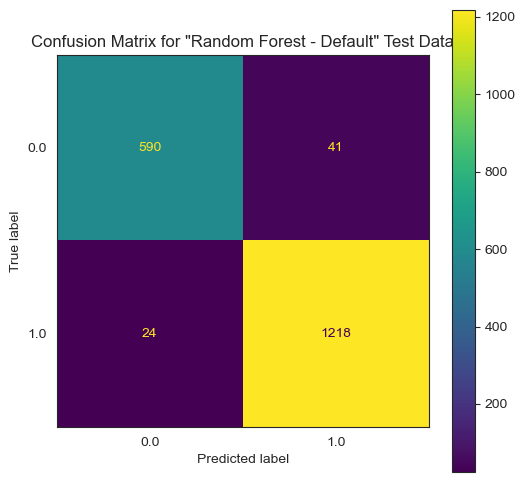

In [137]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model, ET1, XGB1, rf1]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# Conclusions:

Without fail, ExtraTreesClassifer from sklearn.ensemble performed at the very top of every iteration of models, generally followed by RandomForest and XGBoost classifiers. The voting and stacking ensembles sometimes leapfrogged, but ExtraTrees was a reliable outperformer. I am a bit concerned that so many of these models were able to achieve AUC's near 1.0, meaning that they were close to perfect. I think that one more key takeaway is that these models reinforce the ideas behind being a "Macro-economic" investor, given that the most important features were nearly always GDP and Federal Interest Rates. Out of the technical indicators, ATR seemed to have the highest impact on classification. ATR is calculated by looking at daily prices; their high - low, high - previous close, and low - previous close, taking the largest of those 3 values, and adding it to a short-term moving average, making use of short-term data. I find it interesting that it was still a priority factor in longer time horizons as well. When investing at the index level, if minimizing risk is your objective, staying out of the market when interest rates are rising is a good basic tenet to adhere to.